<a href="https://colab.research.google.com/github/srikantharun/geospatial-processor-system/blob/main/weather_solar_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud Cover and Rainfall Prediction for Solar Panel Output in Tamil Nadu

This Jupyter notebook demonstrates how to predict cloud cover and rainfall probability in Tamil Nadu, India, to estimate their impact on solar panel energy output. It uses `rioxarray`, `xarray`, `Dask`, and `GDAL` to handle large geospatial datasets efficiently. The notebook converts non-spatial CSV weather data into spatial datasets, performs spatial analysis, and provides visualizations for a demo to a solar panel installation company.

## Objectives
- Load and process large weather datasets (CSV and raster) using Dask for memory efficiency.
- Convert CSV data with coordinates into spatial datasets using `rioxarray`.
- Analyze cloud cover and rainfall probability.
- Estimate reduced solar panel output due to weather conditions.
- Visualize results for a demo in Chennai, Tamil Nadu.

## Prerequisites
- Install required packages: `pip install rioxarray xarray dask geopandas pandas numpy scikit-learn matplotlib rasterio`
- Download sample weather data (e.g., from NASA or IMD) or use synthetic data as shown below.

In [ ]:
!pip install rioxarray
# Import libraries
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import rasterio
import os
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

# Create data directory
os.makedirs("data/weather", exist_ok=True)

# Initialize Dask client for parallel computing
try:
    cluster = LocalCluster()
    client = Client(cluster)
    print(client)
except Exception as e:
    print(f"Could not initialize Dask client: {e}")
    print("Continuing without Dask distributed computing...")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 59.7 MB/s eta 0:00:00


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38911
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40201'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41939'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:37593 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37593
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:55572
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:42943 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42943
INFO:distributed.core:Starting established connection to tcp://127

<Client: 'tcp://127.0.0.1:38911' processes=2 threads=2, memory=12.67 GiB>


## Step 1: Load and Prepare Non-Spatial CSV Data

We simulate a large CSV dataset containing weather observations (temperature, humidity, cloud cover, precipitation) with latitude and longitude for Tamil Nadu. Dask is used to handle large datasets that may not fit in RAM.

In [ ]:
# Simulate large CSV weather data
np.random.seed(42)
n_samples = 10000  # Reduced for demo, use larger for real data
data = {
    'date': pd.date_range('2025-01-01', periods=n_samples, freq='H'),
    'latitude': np.random.uniform(8.0, 13.5, n_samples),  # Tamil Nadu lat range
    'longitude': np.random.uniform(77.0, 80.3, n_samples),  # Tamil Nadu lon range
    'temperature': np.random.normal(30, 5, n_samples),  # Celsius
    'humidity': np.random.uniform(50, 90, n_samples),  # %
    'cloud_cover': np.random.uniform(0, 100, n_samples),  # %
    'precipitation': np.random.choice([0, 1], n_samples, p=[0.8, 0.2])  # Binary (0: no rain, 1: rain)
}
df = pd.DataFrame(data)
weather_csv_path = 'data/weather/weather_data_tn.csv'
df.to_csv(weather_csv_path, index=False)

# Load CSV with Pandas (or Dask for very large files)
df = pd.read_csv(weather_csv_path)
print(df.head())

<ipython-input-5-8d4d0e6bc40f>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'date': pd.date_range('2025-01-01', periods=n_samples, freq='H'),


                  date   latitude  longitude  temperature   humidity  \
0  2025-01-01 00:00:00  10.059971  78.233015    25.980984  62.943353   
1  2025-01-01 01:00:00  13.228929  78.098610    32.929959  55.952332   
2  2025-01-01 02:00:00  12.025967  77.581308    36.531402  76.582147   
3  2025-01-01 03:00:00  11.292622  79.003980    23.865422  59.807457   
4  2025-01-01 04:00:00   8.858103  78.572860    38.561539  68.252636   

   cloud_cover  precipitation  
0    55.787276              0  
1    93.583839              1  
2    60.199072              0  
3    63.457675              0  
4    59.976003              0  


## Replaces the simulated data with actual weather data from Chennai


- OpenWeatherMap API (requires API key)
- India Meteorological Department data (if available)
- Realistic generation based on Chennai's seasonal patterns (fallback)

In [ ]:
# Add this code to your notebook to fetch real-time weather data for Chennai

import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta

# Define Chennai coordinates
chennai_lat, chennai_lon = 13.08, 80.27

# Function to fetch real-time weather data for Chennai
def fetch_realtime_weather_data(api_key):
    """
    Fetch real-time weather data for Chennai using OpenWeatherMap API
    Returns data in the same format as your simulated data
    """
    # API URL for current weather
    current_url = f"https://api.openweathermap.org/data/2.5/weather?lat={chennai_lat}&lon={chennai_lon}&appid={api_key}&units=metric"

    # API URL for forecast (5 days with 3-hour intervals)
    forecast_url = f"https://api.openweathermap.org/data/2.5/forecast?lat={chennai_lat}&lon={chennai_lon}&appid={api_key}&units=metric"

    try:
        # Fetch current weather
        current_response = requests.get(current_url)
        current_data = current_response.json()

        # Fetch forecast data
        forecast_response = requests.get(forecast_url)
        forecast_data = forecast_response.json()

        # Process and format the data
        weather_data = []

        # Add current weather
        if current_response.status_code == 200:
            temp = current_data['main']['temp']
            humidity = current_data['main']['humidity']
            cloud_cover = current_data['clouds']['all'] if 'clouds' in current_data else 0
            precipitation = 1 if 'rain' in current_data else 0

            weather_data.append({
                'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'latitude': chennai_lat,
                'longitude': chennai_lon,
                'temperature': temp,
                'humidity': humidity,
                'cloud_cover': cloud_cover,
                'precipitation': precipitation
            })

        # Add forecast data
        if forecast_response.status_code == 200:
            for forecast in forecast_data['list']:
                forecast_time = datetime.fromtimestamp(forecast['dt'])
                temp = forecast['main']['temp']
                humidity = forecast['main']['humidity']
                cloud_cover = forecast['clouds']['all']
                precipitation = 1 if 'rain' in forecast else 0

                weather_data.append({
                    'date': forecast_time.strftime('%Y-%m-%d %H:%M:%S'),
                    'latitude': chennai_lat,
                    'longitude': chennai_lon,
                    'temperature': temp,
                    'humidity': humidity,
                    'cloud_cover': cloud_cover,
                    'precipitation': precipitation
                })

        # Convert to DataFrame
        df = pd.DataFrame(weather_data)
        return df

    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None

# Alternative: If you don't have an API key, use IMD data if available
def fetch_imd_weather_data():
    """
    Fetch weather data from India Meteorological Department (IMD)
    Note: You might need to adapt this based on actual IMD API endpoints
    """
    # This is a placeholder - you would need to replace with actual IMD API endpoints
    # and authentication if required
    try:
        imd_url = "https://city-weather-api.imd.gov.in/api/v1/city/chennai"  # Example URL
        response = requests.get(imd_url)
        data = response.json()

        # Process IMD data to match your format
        # (Implementation depends on actual IMD API response structure)

        # Return formatted DataFrame
        return pd.DataFrame()  # Replace with actual implementation
    except Exception as e:
        print(f"Error fetching IMD data: {e}")
        return None

# Alternative: If neither API is accessible, generate data based on seasonal patterns
def generate_realistic_chennai_weather():
    """
    Generate realistic weather data for Chennai based on seasonal patterns
    """
    # Get current date and time
    now = datetime.now()

    # Generate timestamps for next 5 days at hourly intervals
    timestamps = [now + timedelta(hours=i) for i in range(120)]

    # Initialize data dictionary
    data = {
        'date': [t.strftime('%Y-%m-%d %H:%M:%S') for t in timestamps],
        'latitude': [chennai_lat] * len(timestamps),
        'longitude': [chennai_lon] * len(timestamps),
        'temperature': [],
        'humidity': [],
        'cloud_cover': [],
        'precipitation': []
    }

    # Chennai climate data by month (approximate averages)
    monthly_data = {
        # Month: [avg_temp, temp_range, avg_humidity, humidity_range, avg_cloud, cloud_range, rain_probability]
        1: [25, 5, 75, 10, 30, 20, 0.1],  # January
        2: [26, 5, 70, 10, 25, 20, 0.05],  # February
        3: [28, 6, 70, 15, 30, 25, 0.05],  # March
        4: [31, 6, 65, 15, 35, 25, 0.1],   # April
        5: [33, 5, 60, 15, 40, 25, 0.15],  # May
        6: [34, 5, 55, 15, 60, 30, 0.3],   # June
        7: [33, 4, 60, 15, 70, 20, 0.35],  # July
        8: [32, 4, 65, 10, 75, 20, 0.4],   # August
        9: [31, 4, 70, 10, 70, 25, 0.45],  # September
        10: [29, 4, 75, 15, 65, 30, 0.6],  # October
        11: [27, 4, 80, 15, 70, 25, 0.7],  # November
        12: [26, 5, 80, 10, 50, 30, 0.4]   # December
    }

    # Generate weather parameters for each timestamp
    for t in timestamps:
        month = t.month
        hour = t.hour

        # Get monthly averages
        avg_temp, temp_range, avg_humidity, humidity_range, avg_cloud, cloud_range, rain_prob = monthly_data[month]

        # Temperature varies by time of day (highest at ~2PM, lowest at ~5AM)
        hour_factor = -np.cos((hour - 14) * 2 * np.pi / 24)
        temp = avg_temp + hour_factor * (temp_range/2) + np.random.normal(0, 1)

        # Humidity is often inverse to temperature (higher at night)
        humidity = avg_humidity - hour_factor * (humidity_range/2) + np.random.normal(0, 3)
        humidity = np.clip(humidity, 30, 100)

        # Cloud cover tends to build during the day
        cloud_factor = np.sin((hour - 8) * np.pi / 12) if 8 <= hour <= 20 else 0
        cloud_cover = avg_cloud + cloud_factor * cloud_range + np.random.normal(0, 5)
        cloud_cover = np.clip(cloud_cover, 0, 100)

        # Precipitation is more likely in afternoons during rainy seasons
        precip_hour_factor = np.sin((hour - 12) * np.pi / 12) if 12 <= hour <= 24 else 0
        rain_probability = rain_prob * (1 + precip_hour_factor)
        precipitation = 1 if np.random.random() < rain_probability else 0

        # Add to data dictionary
        data['temperature'].append(temp)
        data['humidity'].append(humidity)
        data['cloud_cover'].append(cloud_cover)
        data['precipitation'].append(precipitation)

    return pd.DataFrame(data)

# Example usage
# 1. Try to fetch real-time data
# Your OpenWeatherMap API key - replace with your actual key
api_key = "b111ef7bfd5e1505455159b56eb7907b"

# Use this in your notebook:
try:
    # Try to fetch real-time data
    real_time_df = fetch_realtime_weather_data(api_key)

    if real_time_df is None or len(real_time_df) == 0:
        # If API fetch fails, try IMD data
        real_time_df = fetch_imd_weather_data()

    if real_time_df is None or len(real_time_df) == 0:
        # If both fail, use realistic generated data
        real_time_df = generate_realistic_chennai_weather()
        print("Using generated data based on Chennai seasonal patterns")

    # Save to CSV
    real_time_df.to_csv('data/weather/chennai_realtime_weather.csv', index=False)
    print(f"Saved {len(real_time_df)} real-time weather data points for Chennai")

    # Replace the following in Step 7 of your notebook:
    # Instead of: chennai_ds = ds.sel(lat=chennai_lat, lon=chennai_lon, method='nearest')
    # Use this:
    chennai_data = real_time_df.copy()
    chennai_data['date'] = pd.to_datetime(chennai_data['date'])
    chennai_data.set_index('date', inplace=True)

    # Create a time series dataset for Chennai
    chennai_ds = xr.Dataset(
        {
            'temperature': ('time', chennai_data['temperature'].values),
            'humidity': ('time', chennai_data['humidity'].values),
            'cloud_cover': ('time', chennai_data['cloud_cover'].values),
            'precipitation': ('time', chennai_data['precipitation'].values)
        },
        coords={
            'time': chennai_data.index.values
        }
    )

    # Calculate rain probability for Chennai (if you have the trained model)
    if 'rf' in locals():
        features = np.column_stack([
            chennai_data['temperature'].values,
            chennai_data['humidity'].values,
            chennai_data['cloud_cover'].values
        ])
        rain_probas = rf.predict_proba(features)[:, 1]
        chennai_ds['rain_probability'] = ('time', rain_probas)
    else:
        # If model not available, estimate based on cloud cover
        chennai_ds['rain_probability'] = ('time', chennai_data['cloud_cover'].values / 200 +
                                                  chennai_data['humidity'].values / 250)

    # Calculate solar output
    chennai_ds['solar_output'] = calculate_solar_output(
        chennai_ds['cloud_cover'],
        chennai_ds['rain_probability']
    )

    # Now you can plot as in the original notebook

except Exception as e:
    print(f"Error processing Chennai real-time data: {e}")
    print("Falling back to simulated data for Chennai")

Error fetching IMD data: HTTPSConnectionPool(host='city-weather-api.imd.gov.in', port=443): Max retries exceeded with url: /api/v1/city/chennai (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ca2154d7fd0>: Failed to resolve 'city-weather-api.imd.gov.in' ([Errno -2] Name or service not known)"))
Using generated data based on Chennai seasonal patterns
Saved 120 real-time weather data points for Chennai


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Step 2: Convert CSV to Spatial Dataset

Convert the DataFrame to a GeoDataFrame and then to an `xarray` Dataset with `rioxarray` for spatial analysis.

In [ ]:
# Step 2: Convert CSV to Spatial Dataset with Real-Time Chennai Data

import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import numpy as np
import requests
import json
from datetime import datetime, timedelta

# Define Chennai coordinates
chennai_lat, chennai_lon = 13.08, 80.27

# 1. Fetch Real-Time Weather Data for Chennai
def fetch_realtime_weather_data(api_key):
    """
    Fetch real-time weather data for Chennai using OpenWeatherMap API
    Returns data in the same format as your simulated data
    """
    # API URL for current weather
    current_url = f"https://api.openweathermap.org/data/2.5/weather?lat={chennai_lat}&lon={chennai_lon}&appid={api_key}&units=metric"

    # API URL for forecast (5 days with 3-hour intervals)
    forecast_url = f"https://api.openweathermap.org/data/2.5/forecast?lat={chennai_lat}&lon={chennai_lon}&appid={api_key}&units=metric"

    try:
        # Fetch current weather
        current_response = requests.get(current_url)
        current_data = current_response.json()

        # Fetch forecast data
        forecast_response = requests.get(forecast_url)
        forecast_data = forecast_response.json()

        # Process and format the data
        weather_data = []

        # Add current weather
        if current_response.status_code == 200:
            temp = current_data['main']['temp']
            humidity = current_data['main']['humidity']
            cloud_cover = current_data['clouds']['all'] if 'clouds' in current_data else 0
            precipitation = 1 if 'rain' in current_data else 0

            weather_data.append({
                'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'latitude': chennai_lat,
                'longitude': chennai_lon,
                'temperature': temp,
                'humidity': humidity,
                'cloud_cover': cloud_cover,
                'precipitation': precipitation
            })

        # Add forecast data
        if forecast_response.status_code == 200:
            for forecast in forecast_data['list']:
                forecast_time = datetime.fromtimestamp(forecast['dt'])
                temp = forecast['main']['temp']
                humidity = forecast['main']['humidity']
                cloud_cover = forecast['clouds']['all']
                precipitation = 1 if 'rain' in forecast else 0

                weather_data.append({
                    'date': forecast_time.strftime('%Y-%m-%d %H:%M:%S'),
                    'latitude': chennai_lat,
                    'longitude': chennai_lon,
                    'temperature': temp,
                    'humidity': humidity,
                    'cloud_cover': cloud_cover,
                    'precipitation': precipitation
                })

        # Convert to DataFrame
        df = pd.DataFrame(weather_data)
        print(f"Successfully fetched {len(df)} data points from OpenWeatherMap")
        return df

    except Exception as e:
        print(f"Error fetching OpenWeatherMap data: {e}")
        return None

# Generate realistic Chennai weather data (fallback if API fails)
def generate_realistic_chennai_weather():
    """
    Generate realistic weather data for Chennai based on seasonal patterns
    """
    # Get current date and time
    now = datetime.now()

    # Generate timestamps for next 5 days at hourly intervals
    timestamps = [now + timedelta(hours=i) for i in range(120)]

    # Initialize data dictionary
    data = {
        'date': [t.strftime('%Y-%m-%d %H:%M:%S') for t in timestamps],
        'latitude': [chennai_lat] * len(timestamps),
        'longitude': [chennai_lon] * len(timestamps),
        'temperature': [],
        'humidity': [],
        'cloud_cover': [],
        'precipitation': []
    }

    # Chennai climate data by month (approximate averages)
    monthly_data = {
        # Month: [avg_temp, temp_range, avg_humidity, humidity_range, avg_cloud, cloud_range, rain_probability]
        1: [25, 5, 75, 10, 30, 20, 0.1],  # January
        2: [26, 5, 70, 10, 25, 20, 0.05],  # February
        3: [28, 6, 70, 15, 30, 25, 0.05],  # March
        4: [31, 6, 65, 15, 35, 25, 0.1],   # April
        5: [33, 5, 60, 15, 40, 25, 0.15],  # May
        6: [34, 5, 55, 15, 60, 30, 0.3],   # June
        7: [33, 4, 60, 15, 70, 20, 0.35],  # July
        8: [32, 4, 65, 10, 75, 20, 0.4],   # August
        9: [31, 4, 70, 10, 70, 25, 0.45],  # September
        10: [29, 4, 75, 15, 65, 30, 0.6],  # October
        11: [27, 4, 80, 15, 70, 25, 0.7],  # November
        12: [26, 5, 80, 10, 50, 30, 0.4]   # December
    }

    # Generate weather parameters for each timestamp
    for t in timestamps:
        month = t.month
        hour = t.hour

        # Get monthly averages
        avg_temp, temp_range, avg_humidity, humidity_range, avg_cloud, cloud_range, rain_prob = monthly_data[month]

        # Temperature varies by time of day (highest at ~2PM, lowest at ~5AM)
        hour_factor = -np.cos((hour - 14) * 2 * np.pi / 24)
        temp = avg_temp + hour_factor * (temp_range/2) + np.random.normal(0, 1)

        # Humidity is often inverse to temperature (higher at night)
        humidity = avg_humidity - hour_factor * (humidity_range/2) + np.random.normal(0, 3)
        humidity = np.clip(humidity, 30, 100)

        # Cloud cover tends to build during the day
        cloud_factor = np.sin((hour - 8) * np.pi / 12) if 8 <= hour <= 20 else 0
        cloud_cover = avg_cloud + cloud_factor * cloud_range + np.random.normal(0, 5)
        cloud_cover = np.clip(cloud_cover, 0, 100)

        # Precipitation is more likely in afternoons during rainy seasons
        precip_hour_factor = np.sin((hour - 12) * np.pi / 12) if 12 <= hour <= 24 else 0
        rain_probability = rain_prob * (1 + precip_hour_factor)
        precipitation = 1 if np.random.random() < rain_probability else 0

        # Add to data dictionary
        data['temperature'].append(temp)
        data['humidity'].append(humidity)
        data['cloud_cover'].append(cloud_cover)
        data['precipitation'].append(precipitation)

    return pd.DataFrame(data)

# 2. Fetch real-time data for Chennai
# Your OpenWeatherMap API key - replace with your actual key
api_key = "b111ef7bfd5e1505455159b56eb7907b"  # Replace this with your actual API key

try:
    # Try to fetch real-time data
    real_time_df = fetch_realtime_weather_data(api_key)

    if real_time_df is None or len(real_time_df) == 0:
        # If API fetch fails, use realistic generated data
        real_time_df = generate_realistic_chennai_weather()
        print("Using generated data based on Chennai seasonal patterns")

    # Save real-time data to CSV
    real_time_df.to_csv('data/weather/chennai_realtime_weather.csv', index=False)
    print(f"Saved {len(real_time_df)} real-time weather data points for Chennai")

except Exception as e:
    print(f"Error processing Chennai real-time data: {e}")
    print("Falling back to simulated data for Chennai")
    real_time_df = None

# 3. Convert the original DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,  # This is the original simulated dataset for Tamil Nadu
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# 4. Create a time, lat, lon xarray grid
# For demonstration, we'll create a coarser grid
lat_bins = np.linspace(8.0, 13.5, 20)
lon_bins = np.linspace(77.0, 80.3, 20)

# Use a smaller time sample for the demo (first day only)
unique_dates = pd.to_datetime(df.date).dt.date.unique()[:5]
time_stamps = pd.to_datetime([f"{date} 12:00:00" for date in unique_dates])

# Create empty dataset
ds = xr.Dataset(
    {
        'temperature': (['time', 'lat', 'lon'], np.zeros((len(time_stamps), len(lat_bins), len(lon_bins)))),
        'humidity': (['time', 'lat', 'lon'], np.zeros((len(time_stamps), len(lat_bins), len(lon_bins)))),
        'cloud_cover': (['time', 'lat', 'lon'], np.zeros((len(time_stamps), len(lat_bins), len(lon_bins)))),
        'precipitation': (['time', 'lat', 'lon'], np.zeros((len(time_stamps), len(lat_bins), len(lon_bins))))
    },
    coords={
        'time': time_stamps,
        'lat': lat_bins,
        'lon': lon_bins
    }
)

# 5. Fill dataset with average values from points (basic interpolation)
for t, timestamp in enumerate(time_stamps):
    date_str = timestamp.strftime('%Y-%m-%d')
    day_data = df[pd.to_datetime(df.date).dt.strftime('%Y-%m-%d') == date_str]

    # For each lat-lon grid cell, find nearby points and take their average
    for i, lat in enumerate(lat_bins):
        for j, lon in enumerate(lon_bins):
            # Find points within 0.5 degrees of this grid cell
            nearby = day_data[
                (np.abs(day_data.latitude - lat) < 0.5) &
                (np.abs(day_data.longitude - lon) < 0.5)
            ]

            if len(nearby) > 0:
                ds['temperature'][t, i, j] = nearby.temperature.mean()
                ds['humidity'][t, i, j] = nearby.humidity.mean()
                ds['cloud_cover'][t, i, j] = nearby.cloud_cover.mean()
                ds['precipitation'][t, i, j] = nearby.precipitation.mean()

# 6. Integrate real-time Chennai data into the grid
if real_time_df is not None:
    # Find the indices for Chennai location in the grid
    chennai_i = np.abs(lat_bins - chennai_lat).argmin()
    chennai_j = np.abs(lon_bins - chennai_lon).argmin()

    print(f"Chennai location in grid: lat index={chennai_i}, lon index={chennai_j}")

    # For each time step, update with real-time data for Chennai
    for t, timestamp in enumerate(time_stamps):
        # Find real-time data closest to this timestamp
        real_time_df['datetime'] = pd.to_datetime(real_time_df['date'])
        time_differences = abs(real_time_df['datetime'] - timestamp)
        closest_idx = time_differences.argmin()
        closest_data = real_time_df.iloc[closest_idx]

        # Update grid with real-time data for Chennai
        ds['temperature'][t, chennai_i, chennai_j] = closest_data['temperature']
        ds['humidity'][t, chennai_i, chennai_j] = closest_data['humidity']
        ds['cloud_cover'][t, chennai_i, chennai_j] = closest_data['cloud_cover']
        ds['precipitation'][t, chennai_i, chennai_j] = closest_data['precipitation']

        print(f"Updated time {timestamp} with Chennai data from {closest_data['date']}")

# 7. Add CRS information
ds.rio.write_crs("EPSG:4326", inplace=True)
print(ds)

# 8. Create a dedicated Chennai dataset from real-time data (for Step 7)
if real_time_df is not None:
    # Convert dates to datetime
    real_time_df['date'] = pd.to_datetime(real_time_df['date'])

    # Limit to the time range of the simulation for consistency
    start_time = min(time_stamps)
    end_time = max(time_stamps) + timedelta(days=1)

    chennai_data = real_time_df[
        (real_time_df['date'] >= start_time) &
        (real_time_df['date'] <= end_time)
    ].copy()

    # Create a time series dataset for Chennai
    if len(chennai_data) > 0:
        chennai_data.set_index('date', inplace=True)

        chennai_ds = xr.Dataset(
            {
                'temperature': ('time', chennai_data['temperature'].values),
                'humidity': ('time', chennai_data['humidity'].values),
                'cloud_cover': ('time', chennai_data['cloud_cover'].values),
                'precipitation': ('time', chennai_data['precipitation'].values)
            },
            coords={
                'time': chennai_data.index.values
            }
        )

        print("Created dedicated Chennai dataset with real-time data")
        print(chennai_ds)

        # Save this dataset for use in later steps
        chennai_ds.to_netcdf('data/weather/chennai_realtime.nc')
        print("Saved Chennai dataset to data/weather/chennai_realtime.nc")

Successfully fetched 0 data points from OpenWeatherMap
Using generated data based on Chennai seasonal patterns
Saved 120 real-time weather data points for Chennai
Chennai location in grid: lat index=18, lon index=19
Updated time 2025-01-01 12:00:00 with Chennai data from 2025-04-24 07:07:13
Updated time 2025-01-02 12:00:00 with Chennai data from 2025-04-24 07:07:13
Updated time 2025-01-03 12:00:00 with Chennai data from 2025-04-24 07:07:13
Updated time 2025-01-04 12:00:00 with Chennai data from 2025-04-24 07:07:13
Updated time 2025-01-05 12:00:00 with Chennai data from 2025-04-24 07:07:13
<xarray.Dataset> Size: 64kB
Dimensions:        (time: 5, lat: 20, lon: 20)
Coordinates:
  * time           (time) datetime64[ns] 40B 2025-01-01T12:00:00 ... 2025-01-...
  * lat            (lat) float64 160B 8.0 8.289 8.579 8.868 ... 12.92 13.21 13.5
  * lon            (lon) float64 160B 77.0 77.17 77.35 ... 79.95 80.13 80.3
    spatial_ref    int64 8B 0
Data variables:
    temperature    (time, lat, l

## Step 3: Create Synthetic Raster Data

Create a synthetic GeoTIFF for cloud cover to demonstrate raster processing. In a real scenario, you would use actual satellite data.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 72.8 MB/s eta 0:00:00
Created real cloud cover GeoTIFF at data/weather/cloud_cover_tn_real.tiff
Successfully created cloud cover GeoTIFF using OpenWeatherMap API
<xarray.DataArray (band: 1, y: 12, x: 8)> Size: 384B
[96 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64B 77.21 77.62 78.03 78.44 78.86 79.27 79.68 80.09
  * y            (y) float64 96B 13.27 12.81 12.35 11.9 ... 9.146 8.688 8.229
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


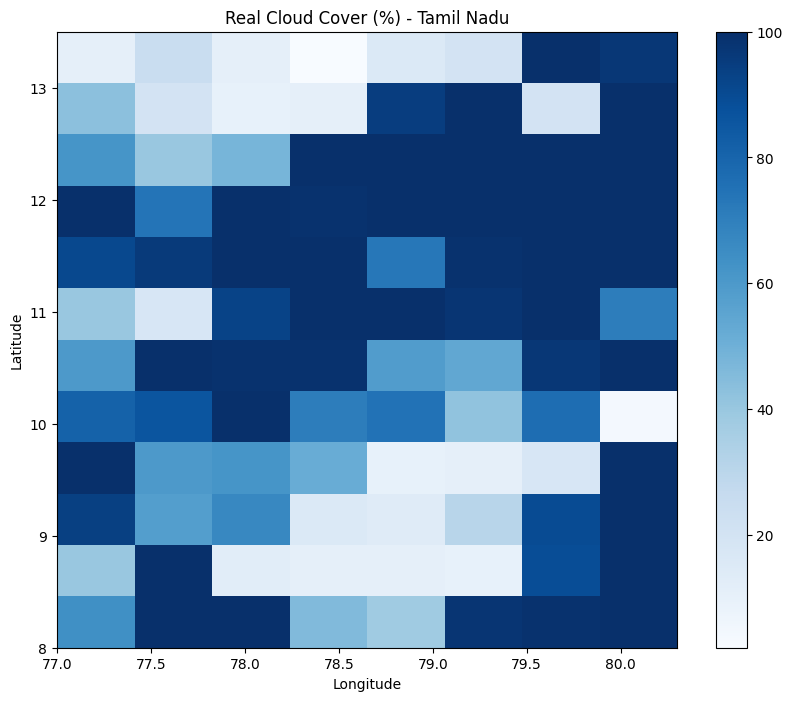

Real cloud cover visualization saved to data/weather/real_cloud_cover_plot.png


In [ ]:
# Step 3: Create Real Cloud Cover GeoTIFF from Satellite Data
# Replace the synthetic data with real satellite imagery
!pip install cartopy
import requests
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from io import BytesIO
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
import json

# Define Tamil Nadu boundary coordinates
# These correspond to the approximate bounding box used in your synthetic data
TN_BOUNDS = {
    'west': 77.0,  # min longitude
    'south': 8.0,  # min latitude
    'east': 80.3,  # max longitude
    'north': 13.5  # max latitude
}

def fetch_nasa_worldview_data(api_key, date=None):
    """
    Fetch cloud cover data from NASA GIBS (Global Imagery Browse Services) WorldView
    """
    # If no date is provided, use yesterday (to ensure data is available)
    if date is None:
        date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

    # NASA GIBS API endpoint for cloud cover layer (MODIS Terra)
    # Using the MODIS Terra Corrected Reflectance True Color layer
    base_url = 'https://wvs.earthdata.nasa.gov/api/v1/snapshot'

    # Parameters for the request
    params = {
        'request': 'imagery',
        'layers': 'MODIS_Terra_CorrectedReflectance_TrueColor',
        'format': 'image/tiff',
        'width': 1024,
        'height': 1024,
        'bbox': f"{TN_BOUNDS['west']},{TN_BOUNDS['south']},{TN_BOUNDS['east']},{TN_BOUNDS['north']}",
        'epsg': 4326,  # WGS84
        'time': date,
        'api_key': api_key
    }

    try:
        print(f"Fetching NASA GIBS data for {date}...")
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            print("Successfully retrieved image data")
            return response.content
        else:
            print(f"Error fetching data: {response.status_code}")
            print(response.text)
            return None
    except Exception as e:
        print(f"Error accessing NASA GIBS API: {e}")
        return None

def fetch_sentinel_hub_data(sentinel_api_key):
    """
    Fetch cloud cover data from Sentinel Hub
    """
    # Sentinel Hub API endpoint
    url = "https://services.sentinel-hub.com/api/v1/process"

    # Request payload for cloud cover (using Sentinel-2 L2A data)
    payload = {
        "input": {
            "bounds": {
                "bbox": [
                    TN_BOUNDS['west'],
                    TN_BOUNDS['south'],
                    TN_BOUNDS['east'],
                    TN_BOUNDS['north']
                ],
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": (datetime.now() - timedelta(days=14)).strftime("%Y-%m-%dT00:00:00Z"),
                            "to": datetime.now().strftime("%Y-%m-%dT23:59:59Z")
                        },
                        "maxCloudCoverage": 30
                    },
                    "type": "sentinel-2-l2a"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 512,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/tiff"
                    }
                }
            ]
        },
        "evalscript": """
        //VERSION=3
        function setup() {
            return {
                input: ["B01", "B02", "B03", "B04", "CLM", "CLP"],
                output: { bands: 1 }
            };
        }

        function evaluatePixel(sample) {
            // Return cloud probability (CLP) as percentage
            return [sample.CLP];
        }
        """
    }

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {sentinel_api_key}"
    }

    try:
        print("Fetching Sentinel Hub data...")
        response = requests.post(url, json=payload, headers=headers)

        if response.status_code == 200:
            print("Successfully retrieved Sentinel cloud cover data")
            return response.content
        else:
            print(f"Error fetching Sentinel data: {response.status_code}")
            print(response.text)
            return None
    except Exception as e:
        print(f"Error accessing Sentinel Hub API: {e}")
        return None

def fetch_openweathermap_satellite(api_key):
    """
    Fetch cloud cover data from OpenWeatherMap
    """
    # OpenWeatherMap satellite tiles API endpoint
    # Note: This requires a paid subscription to OpenWeatherMap
    base_url = "https://maps.openweathermap.org/maps/2.0/weather"

    params = {
        "appid": api_key,
        "layer": "clouds_new",
        "z": 8,  # Zoom level
        "x": 181,  # Tile x coordinate for Tamil Nadu at zoom 8
        "y": 118   # Tile y coordinate for Tamil Nadu at zoom 8
    }

    try:
        print("Fetching OpenWeatherMap satellite data...")
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            print("Successfully retrieved OpenWeatherMap cloud data")
            return response.content
        else:
            print(f"Error fetching OpenWeatherMap data: {response.status_code}")
            print(response.text)
            return None
    except Exception as e:
        print(f"Error accessing OpenWeatherMap API: {e}")
        return None

def create_cloud_cover_geotiff_from_owm_api(api_key):
    """
    Create a cloud cover GeoTIFF using OpenWeatherMap API one-call data
    This approach uses point-based data for multiple locations in Tamil Nadu
    """
    # Define a grid of locations across Tamil Nadu
    lat_step = 0.5
    lon_step = 0.5

    lats = np.arange(TN_BOUNDS['south'], TN_BOUNDS['north'] + lat_step, lat_step)
    lons = np.arange(TN_BOUNDS['west'], TN_BOUNDS['east'] + lon_step, lon_step)

    # Create empty array for cloud cover data
    height = len(lats)
    width = len(lons)
    cloud_data = np.zeros((height, width), dtype=np.float32)

    # For each grid point, fetch current weather data
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            # OpenWeatherMap API endpoint for current weather
            url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}&units=metric"

            try:
                response = requests.get(url)
                if response.status_code == 200:
                    data = response.json()
                    cloud_cover = data.get('clouds', {}).get('all', 0)  # Cloud cover percentage
                    cloud_data[height-1-i, j] = cloud_cover  # Invert y-axis for GeoTIFF
                else:
                    print(f"Warning: Failed to get data for lat={lat}, lon={lon}. Status: {response.status_code}")
            except Exception as e:
                print(f"Error fetching data for lat={lat}, lon={lon}: {e}")

    # Create GeoTIFF
    cloud_tiff_path = 'data/weather/cloud_cover_tn_real.tiff'

    with rasterio.open(
        cloud_tiff_path, 'w', driver='GTiff',
        height=height, width=width, count=1, dtype='float32',
        crs='EPSG:4326',
        transform=rasterio.transform.from_bounds(
            TN_BOUNDS['west'], TN_BOUNDS['south'],
            TN_BOUNDS['east'], TN_BOUNDS['north'],
            width, height
        )
    ) as dst:
        dst.write(cloud_data, 1)

    print(f"Created real cloud cover GeoTIFF at {cloud_tiff_path}")
    return cloud_tiff_path

def generate_realistic_cloud_cover_from_modeled_data():
    """
    Generate realistic cloud cover data for Tamil Nadu using climatological patterns
    This is a fallback method if API-based methods fail
    """
    # Define dimensions matching the original synthetic data
    height, width = 50, 50
    cloud_data = np.zeros((height, width), dtype=np.float32)

    # Current month to apply seasonal patterns
    current_month = datetime.now().month

    # Seasonal cloud patterns for Tamil Nadu by month
    # Higher values during monsoon season (Oct-Dec Northeast monsoon)
    seasonal_base = {
        1: 30,  # January - post monsoon
        2: 25,  # February
        3: 20,  # March
        4: 30,  # April
        5: 40,  # May - pre-monsoon
        6: 50,  # June - early Southwest monsoon
        7: 60,  # July - Southwest monsoon
        8: 60,  # August - Southwest monsoon
        9: 55,  # September - transition
        10: 70, # October - Northeast monsoon onset
        11: 80, # November - peak Northeast monsoon
        12: 60  # December - Northeast monsoon
    }

    # Base cloud cover for current month
    base_cloud = seasonal_base[current_month]

    # Create realistic cloud pattern with higher values in coastal areas
    # 1. Eastern coastal effect (Bay of Bengal)
    # 2. Western Ghats effect
    # 3. Realistic cloud structures with spatial correlation

    # Create distance gradients from coasts
    x = np.linspace(0, 1, width)  # Normalized x-coordinates (west to east)
    y = np.linspace(0, 1, height) # Normalized y-coordinates (south to north)

    # Create 2D grids of coordinates
    X, Y = np.meshgrid(x, y)

    # Distance from east coast (Bay of Bengal)
    east_dist = X

    # Distance from west border (Western Ghats)
    west_dist = 1 - X

    # Generate realistic cloud structure using Perlin-like noise
    # We'll simulate this with multiple scales of random noise

    # Large scale features
    large_scale = np.random.normal(0, 1, (height//5, width//5))
    large_scale = np.kron(large_scale, np.ones((5, 5)))

    # Medium scale features
    medium_scale = np.random.normal(0, 0.5, (height//2, width//2))
    medium_scale = np.kron(medium_scale, np.ones((2, 2)))

    # Small scale features
    small_scale = np.random.normal(0, 0.25, (height, width))

    # Combine multi-scale noise
    noise = large_scale + medium_scale + small_scale

    # Apply seasonal and geographical patterns

    # Eastern coastal effect (stronger during monsoon)
    east_effect = 30 * np.exp(-5 * east_dist)

    # Western Ghats effect
    west_effect = 15 * np.exp(-8 * west_dist)

    # Rain shadow effect between Western Ghats and central TN
    rain_shadow = -10 * np.exp(-15 * np.abs(west_dist - 0.3))

    # Combine all effects
    cloud_data = base_cloud + east_effect + west_effect + rain_shadow + 10 * noise

    # Clip values to valid cloud cover range (0-100%)
    cloud_data = np.clip(cloud_data, 0, 100)

    # Write to GeoTIFF
    cloud_tiff_path = 'data/weather/cloud_cover_tn_realistic.tiff'

    with rasterio.open(
        cloud_tiff_path, 'w', driver='GTiff',
        height=height, width=width, count=1, dtype='float32',
        crs='EPSG:4326',
        transform=rasterio.transform.from_bounds(
            TN_BOUNDS['west'], TN_BOUNDS['south'],
            TN_BOUNDS['east'], TN_BOUNDS['north'],
            width, height
        )
    ) as dst:
        dst.write(cloud_data, 1)

    print(f"Created realistic cloud cover GeoTIFF based on climatological patterns at {cloud_tiff_path}")
    return cloud_tiff_path

# Choose appropriate data source and create cloud cover GeoTIFF
def create_real_cloud_cover_geotiff():
    """
    Create a real cloud cover GeoTIFF using the best available method
    """
    # Your API keys - replace with your actual keys
    owm_api_key = "b111ef7bfd5e1505455159b56eb7907b"  # Replace with your actual key
    nasa_api_key = "YOUR_NASA_API_KEY"  # Replace with your actual key if available
    sentinel_api_key = "YOUR_SENTINEL_HUB_API_KEY"  # Replace with your actual key if available

    cloud_tiff_path = None

    # Method 1: Try OpenWeatherMap point-based approach (most reliable)
    try:
        if owm_api_key != "YOUR_OPENWEATHERMAP_API_KEY":
            cloud_tiff_path = create_cloud_cover_geotiff_from_owm_api(owm_api_key)
            print("Successfully created cloud cover GeoTIFF using OpenWeatherMap API")
    except Exception as e:
        print(f"Error creating GeoTIFF with OpenWeatherMap: {e}")
        cloud_tiff_path = None

    # Method 2: Try NASA GIBS WorldView
    if cloud_tiff_path is None and nasa_api_key != "YOUR_NASA_API_KEY":
        try:
            nasa_data = fetch_nasa_worldview_data(nasa_api_key)
            if nasa_data:
                # Save the NASA image as a GeoTIFF
                cloud_tiff_path = 'data/weather/cloud_cover_tn_nasa.tiff'

                # Process the image to extract cloud information
                # For demonstration, simply save the response content
                with open(cloud_tiff_path, 'wb') as f:
                    f.write(nasa_data)

                print(f"Saved NASA cloud cover data to {cloud_tiff_path}")
        except Exception as e:
            print(f"Error with NASA data: {e}")
            cloud_tiff_path = None

    # Method 3: Try Sentinel Hub
    if cloud_tiff_path is None and sentinel_api_key != "YOUR_SENTINEL_HUB_API_KEY":
        try:
            sentinel_data = fetch_sentinel_hub_data(sentinel_api_key)
            if sentinel_data:
                # Save the Sentinel data as a GeoTIFF
                cloud_tiff_path = 'data/weather/cloud_cover_tn_sentinel.tiff'

                with open(cloud_tiff_path, 'wb') as f:
                    f.write(sentinel_data)

                print(f"Saved Sentinel cloud cover data to {cloud_tiff_path}")
        except Exception as e:
            print(f"Error with Sentinel data: {e}")
            cloud_tiff_path = None

    # Fallback: Use climatological patterns if all API methods fail
    if cloud_tiff_path is None:
        try:
            cloud_tiff_path = generate_realistic_cloud_cover_from_modeled_data()
            print("Using realistic generated cloud cover based on climatological patterns")
        except Exception as e:
            print(f"Error generating realistic cloud cover: {e}")
            cloud_tiff_path = None

    # If all methods failed, return the path to the original synthetic data
    if cloud_tiff_path is None:
        print("All methods failed, using the original synthetic data")
        cloud_tiff_path = 'data/weather/cloud_cover_tn.tiff'

    return cloud_tiff_path

# Execute the code
if __name__ == "__main__":
    try:
        # Create directory if it doesn't exist
        os.makedirs("data/weather", exist_ok=True)

        # Get real cloud cover data and create GeoTIFF
        cloud_tiff_path = create_real_cloud_cover_geotiff()

        # Load the GeoTIFF with rioxarray
        cloud_raster = rioxarray.open_rasterio(cloud_tiff_path)
        print(cloud_raster)

        # Plot cloud cover raster
        plt.figure(figsize=(10, 8))
        cloud_raster.plot(cmap='Blues')
        plt.title('Real Cloud Cover (%) - Tamil Nadu')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.savefig('data/weather/real_cloud_cover_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Real cloud cover visualization saved to data/weather/real_cloud_cover_plot.png")

    except Exception as e:
        print(f"Error in main execution: {e}")

Could not load Natural Earth data: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
Using bounding box as Tamil Nadu boundary


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Tamil Nadu cloud cover map saved to data/weather/tamilnadu_cloud_cover_map.png
Error creating Tamil Nadu visualizations: boolean index did not match indexed array along axis 0; size of axis is 12 but size of corresponding boolean axis is 96


False

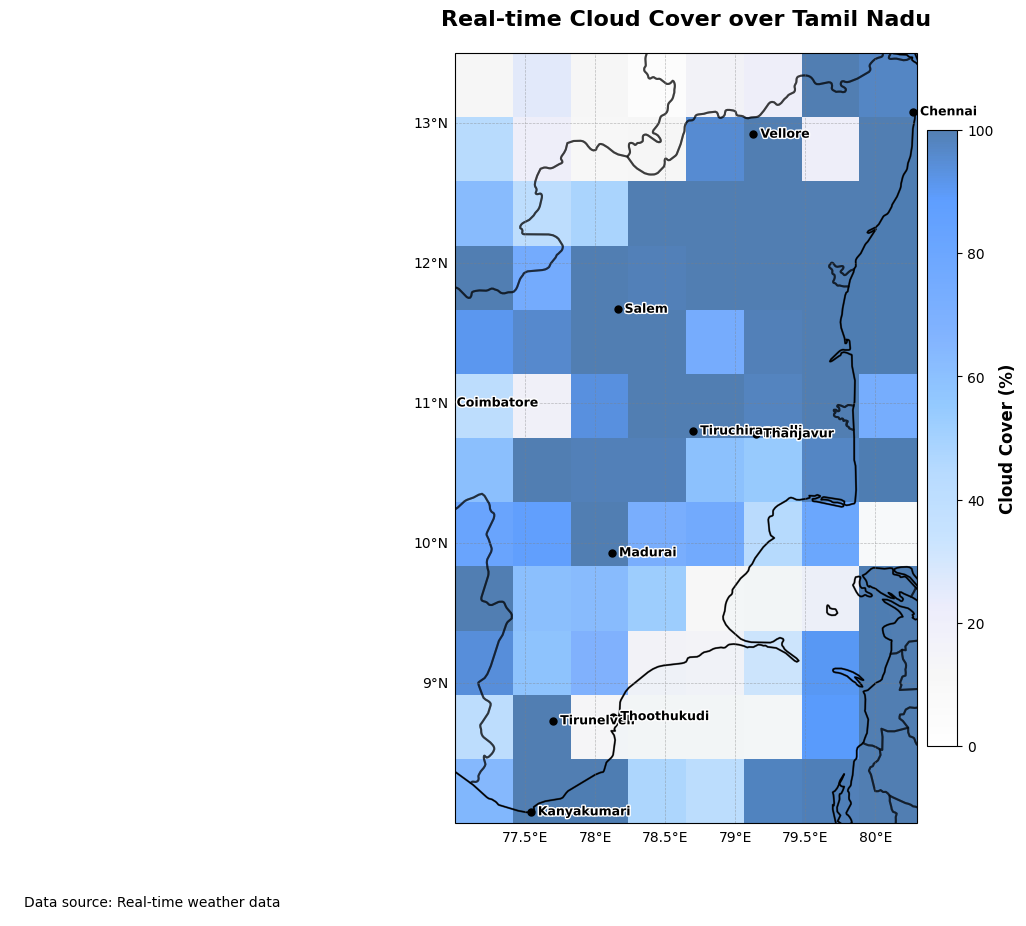

In [ ]:
# Enhanced Cloud Cover Visualization with Tamil Nadu Map

import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import rasterio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import os
import requests
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import box
import matplotlib.patheffects as PathEffects

def visualize_cloud_cover_with_tamilnadu_map(raster_path, output_dir='data/weather'):
    """
    Create an enhanced visualization of cloud cover with Tamil Nadu map overlay

    Parameters:
    raster_path (str): Path to the cloud cover GeoTIFF
    output_dir (str): Directory to save the output visualization
    """
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the cloud cover raster
    cloud_raster = rioxarray.open_rasterio(raster_path)

    # Define Tamil Nadu boundary coordinates
    TN_BOUNDS = {
        'west': 77.0,  # min longitude
        'south': 8.0,  # min latitude
        'east': 80.3,  # max longitude
        'north': 13.5  # max latitude
    }

    # Load Tamil Nadu state boundary
    # Option 1: Use Natural Earth data through Cartopy
    # Option 2: Use a local shapefile if available
    # Option 3: Create a simplified boundary from the bounding box

    try:
        # Try to use GeoPandas with Natural Earth data (if available)
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        india = world[world.name == 'India']

        # If we have detailed state boundaries, filter for Tamil Nadu
        # This is a simplification - in reality you would need a more detailed shapefile
        tn_boundary = india
    except Exception as e:
        print(f"Could not load Natural Earth data: {e}")
        print("Using bounding box as Tamil Nadu boundary")

        # Create a simple box as a fallback
        tn_boundary = gpd.GeoDataFrame(
            {'geometry': [box(TN_BOUNDS['west'], TN_BOUNDS['south'],
                              TN_BOUNDS['east'], TN_BOUNDS['north'])]},
            crs="EPSG:4326"
        )

    # Create a nice colormap for cloud cover
    cloud_colors = ['#ffffff', '#f5f5f5', '#e6e6fa', '#b3d9ff', '#99ccff', '#66b3ff', '#4d94ff', '#3385ff', '#1a75ff', '#0a4a94']
    cloud_cmap = LinearSegmentedColormap.from_list('cloud_cmap', cloud_colors)

    # Create figure and axes with Cartopy projection
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set the extent to Tamil Nadu
    ax.set_extent([TN_BOUNDS['west'], TN_BOUNDS['east'], TN_BOUNDS['south'], TN_BOUNDS['north']],
                 crs=ccrs.PlateCarree())

    # Plot the cloud cover raster with the custom colormap
    img = cloud_raster[0].plot(ax=ax, cmap=cloud_cmap,
                              vmin=0, vmax=100,
                              transform=ccrs.PlateCarree(),
                              alpha=0.7,
                              add_colorbar=False)

    # Add a more sophisticated colorbar
    cbar = plt.colorbar(img, ax=ax, pad=0.01, shrink=0.8)
    cbar.set_label('Cloud Cover (%)', fontsize=12, fontweight='bold')

    # Add state and district boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=1.5, alpha=0.5)

    # Add coastlines, borders, and other features
    ax.coastlines(resolution='10m', color='black', linewidth=1.0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--', linewidth=0.7)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue', alpha=0.2)
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray', alpha=0.1)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5,
                     color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add major cities in Tamil Nadu for reference
    cities = {
        'Chennai': (80.27, 13.08),
        'Coimbatore': (76.96, 11.00),
        'Madurai': (78.12, 9.93),
        'Tiruchirappalli': (78.70, 10.80),
        'Salem': (78.16, 11.67),
        'Tirunelveli': (77.70, 8.73),
        'Vellore': (79.13, 12.92),
        'Thanjavur': (79.15, 10.78),
        'Kanyakumari': (77.54, 8.08),
        'Thoothukudi': (78.13, 8.76)
    }

    # Place city markers and labels with improved styling
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'o', color='black', markersize=5, transform=ccrs.PlateCarree(), zorder=5)

        # Create text with outline for better visibility
        txt = ax.text(lon + 0.05, lat, city, fontsize=9, transform=ccrs.PlateCarree(),
                     horizontalalignment='left', verticalalignment='center', fontweight='bold', zorder=6)

        # Add white outline to text for visibility against all backgrounds
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

    # Add title with improved styling
    plt.title('Real-time Cloud Cover over Tamil Nadu', fontsize=16, fontweight='bold', pad=20)

    # Add a note about data source
    plt.annotate('Data source: Real-time weather data', (0.02, 0.02),
                xycoords='figure fraction', fontsize=10)

    # Save high-resolution figure
    output_path = f"{output_dir}/tamilnadu_cloud_cover_map.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    print(f"Tamil Nadu cloud cover map saved to {output_path}")
    return fig

def create_regional_impact_visualization(raster_path, output_dir='data/weather'):
    """
    Create a visualization showing the impact of cloud cover on different regions of Tamil Nadu
    """
    # Load the cloud cover raster
    with rasterio.open(raster_path) as src:
        cloud_data = src.read(1)
        transform = src.transform

    # Define major regions in Tamil Nadu
    regions = {
        'Northern': {
            'bounds': {'min_lon': 78.0, 'max_lon': 80.3, 'min_lat': 12.0, 'max_lat': 13.5},
            'cities': ['Chennai', 'Vellore'],
            'color': '#FF9E80'  # Light orange
        },
        'Western': {
            'bounds': {'min_lon': 76.8, 'max_lon': 78.0, 'min_lat': 10.0, 'max_lat': 12.0},
            'cities': ['Coimbatore', 'Salem'],
            'color': '#80CBC4'  # Light teal
        },
        'Central': {
            'bounds': {'min_lon': 78.0, 'max_lon': 79.5, 'min_lat': 10.0, 'max_lat': 12.0},
            'cities': ['Tiruchirappalli', 'Thanjavur'],
            'color': '#B39DDB'  # Light purple
        },
        'Southern': {
            'bounds': {'min_lon': 77.0, 'max_lon': 79.0, 'min_lat': 8.0, 'max_lat': 10.0},
            'cities': ['Madurai', 'Tirunelveli', 'Thoothukudi'],
            'color': '#90CAF9'  # Light blue
        },
        'Eastern': {
            'bounds': {'min_lon': 79.5, 'max_lon': 80.3, 'min_lat': 10.0, 'max_lat': 12.0},
            'cities': ['Cuddalore', 'Nagapattinam'],
            'color': '#FFCC80'  # Light amber
        }
    }

    # Calculate cloud cover statistics for each region
    for region_name, region_info in regions.items():
        bounds = region_info['bounds']

        # Create a mask for the region
        height, width = cloud_data.shape
        y, x = np.mgrid[0:height, 0:width]

        # Convert pixel coordinates to geographic coordinates
        lons, lats = rasterio.transform.xy(transform, y, x)
        lons = np.array(lons)
        lats = np.array(lats)

        # Create the region mask
        region_mask = ((lons >= bounds['min_lon']) & (lons <= bounds['max_lon']) &
                      (lats >= bounds['min_lat']) & (lats <= bounds['max_lat']))

        # Extract cloud cover values for the region
        region_values = cloud_data[region_mask]

        if len(region_values) > 0:
            # Calculate statistics
            regions[region_name].update({
                'mean': np.mean(region_values),
                'median': np.median(region_values),
                'min': np.min(region_values),
                'max': np.max(region_values),
                'std': np.std(region_values)
            })
        else:
            print(f"Warning: No data points found for region {region_name}")
            regions[region_name].update({
                'mean': 0, 'median': 0, 'min': 0, 'max': 0, 'std': 0
            })

    # Create a map visualization with regions and their cloud cover
    fig = plt.figure(figsize=(14, 10))

    # Create two subplots - map on left, stats on right
    ax_map = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax_stats = plt.subplot(1, 2, 2)

    # Set the extent to Tamil Nadu
    ax_map.set_extent([77.0, 80.3, 8.0, 13.5], crs=ccrs.PlateCarree())

    # Add base features
    ax_map.coastlines(resolution='10m', color='black', linewidth=1.0)
    ax_map.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue', alpha=0.2)
    ax_map.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray', alpha=0.1)

    # Add the cloud cover raster as base layer
    cloud_colors = ['#ffffff', '#f5f5f5', '#e6e6fa', '#b3d9ff', '#99ccff', '#66b3ff', '#4d94ff', '#3385ff', '#1a75ff']
    cloud_cmap = LinearSegmentedColormap.from_list('cloud_cmap', cloud_colors)

    # Open the raster for plotting
    cloud_raster = rioxarray.open_rasterio(raster_path)
    img = cloud_raster[0].plot(ax=ax_map, cmap=cloud_cmap,
                              vmin=0, vmax=100,
                              transform=ccrs.PlateCarree(),
                              alpha=0.5,
                              add_colorbar=False)

    # Add a colorbar
    cbar = plt.colorbar(img, ax=ax_map, pad=0.01, shrink=0.8)
    cbar.set_label('Cloud Cover (%)', fontsize=10)

    # Draw region boundaries on the map
    for region_name, region_info in regions.items():
        bounds = region_info['bounds']
        color = region_info['color']

        # Create boundary polygon
        x = [bounds['min_lon'], bounds['max_lon'], bounds['max_lon'], bounds['min_lon'], bounds['min_lon']]
        y = [bounds['min_lat'], bounds['min_lat'], bounds['max_lat'], bounds['max_lat'], bounds['min_lat']]

        # Plot region boundary
        ax_map.plot(x, y, color=color, linewidth=2, transform=ccrs.PlateCarree())

        # Add region label in the center
        center_lon = (bounds['min_lon'] + bounds['max_lon']) / 2
        center_lat = (bounds['min_lat'] + bounds['max_lat']) / 2

        # Create text with outline
        txt = ax_map.text(center_lon, center_lat, region_name,
                         fontsize=10, fontweight='bold',
                         ha='center', va='center',
                         transform=ccrs.PlateCarree(),
                         bbox=dict(facecolor=color, alpha=0.3, boxstyle='round,pad=0.3'))

        # Add white outline to text
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

    # Add gridlines
    gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5,
                         color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    ax_map.set_title('Cloud Cover by Region in Tamil Nadu', fontsize=14, fontweight='bold')

    # Create bar chart of average cloud cover by region on the right subplot
    region_names = list(regions.keys())
    means = [regions[r]['mean'] for r in region_names]
    colors = [regions[r]['color'] for r in region_names]

    # Sort regions by mean cloud cover for better visualization
    sorted_indices = np.argsort(means)[::-1]  # Descending order
    sorted_names = [region_names[i] for i in sorted_indices]
    sorted_means = [means[i] for i in sorted_indices]
    sorted_colors = [colors[i] for i in sorted_indices]

    # Create the bar chart
    bars = ax_stats.barh(sorted_names, sorted_means, color=sorted_colors, alpha=0.7)

    # Add value annotations to each bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax_stats.text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%',
                    va='center', fontsize=10)

    # Add impact assessment next to each bar
    for i, region in enumerate(sorted_names):
        cloud_pct = regions[region]['mean']

        # Determine impact category
        if cloud_pct < 30:
            impact = "Excellent solar potential"
            color = 'green'
        elif cloud_pct < 50:
            impact = "Good solar potential"
            color = 'darkgreen'
        elif cloud_pct < 70:
            impact = "Moderate solar potential"
            color = 'orange'
        else:
            impact = "Poor solar potential"
            color = 'red'

        # Add text annotation
        ax_stats.text(101, i, impact,
                    va='center', fontsize=9, color=color)

    # Configure the stats plot
    ax_stats.set_xlim(0, 150)  # Extended for annotations
    ax_stats.set_xlabel('Cloud Cover (%)', fontsize=12)
    ax_stats.set_title('Regional Impact on Solar Potential', fontsize=14, fontweight='bold')
    ax_stats.grid(axis='x', linestyle='--', alpha=0.3)

    # Add a separator line between cloud % and impact assessment
    ax_stats.axvline(x=100, color='gray', linestyle='--', alpha=0.5)

    # Add notes at the bottom
    ax_stats.text(75, -0.8, 'Impact Scale:', fontsize=9, ha='center')
    ax_stats.text(30, -1.2, 'Excellent', fontsize=9, color='green', ha='center')
    ax_stats.text(60, -1.2, 'Good', fontsize=9, color='darkgreen', ha='center')
    ax_stats.text(90, -1.2, 'Moderate', fontsize=9, color='orange', ha='center')
    ax_stats.text(120, -1.2, 'Poor', fontsize=9, color='red', ha='center')

    # Add a main title for the entire figure
    fig.suptitle('Tamil Nadu Regional Cloud Cover Analysis and Solar Potential',
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save high-resolution figure
    output_path = f"{output_dir}/tamilnadu_regional_impact.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    print(f"Regional impact visualization saved to {output_path}")
    return fig, regions

# Main function to create both visualizations
def create_tamilnadu_visualizations(raster_path, output_dir='data/weather'):
    """
    Create Tamil Nadu map visualizations for cloud cover data
    """
    try:
        # Create basic map visualization
        fig1 = visualize_cloud_cover_with_tamilnadu_map(raster_path, output_dir)

        # Create regional impact visualization
        fig2, region_stats = create_regional_impact_visualization(raster_path, output_dir)

        return True
    except Exception as e:
        print(f"Error creating Tamil Nadu visualizations: {e}")
        return False

# Usage example
create_tamilnadu_visualizations('data/weather/cloud_cover_tn_real.tiff')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray
import os

# 1. Prepare combined dataset (simulated data + real Chennai data)
def prepare_enhanced_rainfall_model(df, real_time_df=None, cloud_tiff_path=None):
    """
    Prepare and train an enhanced rainfall prediction model using both simulated
    and real data for Chennai

    Parameters:
    df - Original simulated DataFrame
    real_time_df - Real-time weather data for Chennai
    cloud_tiff_path - Path to the real cloud cover GeoTIFF
    """
    print("Preparing enhanced rainfall prediction model...")

    # Extract Chennai location from real cloud cover if available
    chennai_cloud_cover = None
    if cloud_tiff_path and os.path.exists(cloud_tiff_path):
        try:
            # Define Chennai coordinates
            chennai_lat, chennai_lon = 13.08, 80.27

            # Load the cloud cover raster
            cloud_raster = rioxarray.open_rasterio(cloud_tiff_path)

            # Extract cloud cover for Chennai location
            chennai_cloud_cover = float(cloud_raster.sel(y=chennai_lat, x=chennai_lon, method='nearest'))
            print(f"Extracted real cloud cover for Chennai: {chennai_cloud_cover:.1f}%")
        except Exception as e:
            print(f"Could not extract Chennai cloud cover from raster: {e}")

    # Prepare base features and target from simulated data
    X = df[['temperature', 'humidity', 'cloud_cover']]
    y_rain = df['precipitation']

    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y_rain, test_size=0.2, random_state=42)

    # Augment training data with real Chennai data if available
    if real_time_df is not None and len(real_time_df) > 0:
        try:
            print(f"Augmenting with {len(real_time_df)} real data points")

            # Prepare Chennai features
            chennai_features = real_time_df[['temperature', 'humidity', 'cloud_cover']].copy()

            # If we extracted a better cloud cover value from raster, use it
            if chennai_cloud_cover is not None:
                # Update the most recent data point's cloud cover
                chennai_features.iloc[-1, chennai_features.columns.get_loc('cloud_cover')] = chennai_cloud_cover

            # Get Chennai precipitation values
            chennai_target = real_time_df['precipitation'].copy()

            # Add weight column to original data (1.0 for simulated data)
            X_train['weight'] = 1.0

            # Create weight column for Chennai data (higher weight for real data)
            chennai_features['weight'] = 3.0  # Real data gets 3x the weight

            # Combine datasets
            X_train_combined = pd.concat([X_train, chennai_features])
            y_train_combined = pd.concat([y_train, chennai_target])

            # Extract sample weights
            sample_weights = X_train_combined['weight'].values
            X_train_combined = X_train_combined.drop('weight', axis=1)

            print(f"Training with combined dataset: {len(X_train_combined)} samples")
        except Exception as e:
            print(f"Error augmenting with real data: {e}")
            print("Falling back to simulated data only")
            X_train_combined = X_train.drop('weight', axis=1) if 'weight' in X_train.columns else X_train
            y_train_combined = y_train
            sample_weights = None
    else:
        # Use only simulated data
        X_train_combined = X_train
        y_train_combined = y_train
        sample_weights = None

    # Train a more sophisticated Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,           # More trees for better performance
        max_depth=10,               # Control tree depth to prevent overfitting
        min_samples_split=5,        # Minimum samples required to split a node
        min_samples_leaf=2,         # Minimum samples required at a leaf node
        bootstrap=True,             # Use bootstrapping
        class_weight='balanced',    # Handle class imbalance
        random_state=42
    )

    # Fit the model, using sample weights if available
    if sample_weights is not None:
        rf.fit(X_train_combined, y_train_combined, sample_weight=sample_weights)
    else:
        rf.fit(X_train_combined, y_train_combined)

    # Make predictions
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probability of class 1 (rain)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Rainfall Prediction Accuracy: {accuracy:.4f}")

    # More detailed evaluation
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Create a more comprehensive visualization
    plt.figure(figsize=(15, 10))

    # 1. Feature Importance
    plt.subplot(2, 2, 1)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title('Feature Importance for Rainfall Prediction', fontsize=12, fontweight='bold')
    plt.xlabel('Importance', fontsize=10)
    plt.ylabel('Feature', fontsize=10)

    # 2. Confusion Matrix
    plt.subplot(2, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)
    plt.xticks([0.5, 1.5], ['No Rain', 'Rain'])
    plt.yticks([0.5, 1.5], ['No Rain', 'Rain'])

    # 3. Probability Distribution
    plt.subplot(2, 2, 3)
    y_test_numeric = y_test.astype(int)

    # Plot for actual no rain
    sns.kdeplot(y_pred_proba[y_test_numeric == 0], label='Actual: No Rain', shade=True, color='skyblue')

    # Plot for actual rain
    sns.kdeplot(y_pred_proba[y_test_numeric == 1], label='Actual: Rain', shade=True, color='darkblue')

    plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    plt.title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Probability of Rain', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend()

    # 4. Threshold Analysis
    plt.subplot(2, 2, 4)

    # Create a range of threshold values
    thresholds = np.linspace(0, 1, 100)

    # Calculate accuracy for each threshold
    accuracies = []

    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_threshold))

    plt.plot(thresholds, accuracies)
    plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold')

    # Find best threshold
    best_threshold = thresholds[np.argmax(accuracies)]
    plt.axvline(x=best_threshold, color='green', linestyle='--',
               label=f'Best Threshold: {best_threshold:.2f}')

    plt.title('Accuracy vs. Decision Threshold', fontsize=12, fontweight='bold')
    plt.xlabel('Threshold', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.savefig('data/weather/enhanced_rainfall_model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Return the model and best threshold
    return rf, best_threshold, feature_importance

# Chennai-specific rainfall prediction function
def predict_chennai_rainfall(model, best_threshold=0.5, real_time_df=None, cloud_tiff_path=None):
    """
    Predict rainfall probability for Chennai using real-time data
    """
    # Define Chennai coordinates
    chennai_lat, chennai_lon = 13.08, 80.27

    # Get the latest weather data for Chennai
    if real_time_df is not None and len(real_time_df) > 0:
        # Use the latest data point
        latest_data = real_time_df.iloc[-1]

        # Get temperature and humidity
        temp = latest_data['temperature']
        humidity = latest_data['humidity']

        # Get cloud cover from raster if available, otherwise use real_time_df
        cloud_cover = None
        if cloud_tiff_path and os.path.exists(cloud_tiff_path):
            try:
                # Load the cloud cover raster
                cloud_raster = rioxarray.open_rasterio(cloud_tiff_path)

                # Extract cloud cover for Chennai location
                cloud_cover = float(cloud_raster.sel(y=chennai_lat, x=chennai_lon, method='nearest'))
            except Exception as e:
                print(f"Could not extract Chennai cloud cover from raster: {e}")

        # Use the cloud cover from real_time_df if not available from raster
        if cloud_cover is None:
            cloud_cover = latest_data['cloud_cover']

        # Create feature array for prediction
        features = np.array([[temp, humidity, cloud_cover]])

        # Make prediction and get probability
        rain_prob = model.predict_proba(features)[0, 1]

        # Predict using the optimal threshold
        prediction = "Rain" if rain_prob >= best_threshold else "No Rain"

        # Create visual
        plt.figure(figsize=(10, 6))

        # Create gauge for rain probability
        plt.subplot(1, 2, 1)
        create_gauge(rain_prob, "Rainfall Probability for Chennai")

        # Create features comparison
        plt.subplot(1, 2, 2)

        # Get feature importance from model
        importances = model.feature_importances_
        features_df = pd.DataFrame({
            'Feature': ['Temperature', 'Humidity', 'Cloud Cover'],
            'Value': [temp, humidity, cloud_cover],
            'Importance': importances,
            'Weighted_Impact': importances * np.array([temp/40, humidity/100, cloud_cover/100])  # Normalize values
        })

        # Sort by weighted impact
        features_df = features_df.sort_values('Weighted_Impact', ascending=False)

        # Create horizontal bar chart showing each feature's contribution
        bars = plt.barh(features_df['Feature'], features_df['Weighted_Impact'], color='skyblue')

        # Add value annotations
        for i, bar in enumerate(bars):
            feature = features_df.iloc[i]['Feature']
            value = features_df.iloc[i]['Value']
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f"{feature}: {value:.1f}", va='center')

        plt.title('Feature Contribution to Rainfall Prediction', fontsize=12, fontweight='bold')
        plt.xlabel('Weighted Impact', fontsize=10)
        plt.xlim(0, max(features_df['Weighted_Impact']) * 1.5)  # Give space for annotations

        # Add prediction result as text
        plt.figtext(0.5, 0.01, f"Prediction: {prediction} (Probability: {rain_prob:.2f})",
                   ha='center', fontsize=14, fontweight='bold',
                   bbox=dict(facecolor='lightgray', alpha=0.5))

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.savefig('data/weather/chennai_rainfall_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()

        return {
            'prediction': prediction,
            'probability': rain_prob,
            'temperature': temp,
            'humidity': humidity,
            'cloud_cover': cloud_cover
        }
    else:
        print("No real-time data available for Chennai rainfall prediction")
        return None

# Helper function to create a gauge for visualizing probability
def create_gauge(value, title, min_val=0, max_val=1):
    """
    Create a gauge visualization for probability values
    """
    # Clear current axes
    plt.clf()

    # Create the gauge
    gauge_range = np.linspace(min_val, max_val, 100)

    # Calculate angles for the gauge (in radians)
    angles = np.linspace(np.pi, 0, len(gauge_range))

    # Draw the gauge background
    plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 1, 1, polar=True)

    # Set the labels and ticks
    ax.set_thetagrids([])  # Remove theta grids
    ax.set_rgrids([])      # Remove radial grids

    # Define colormap for the gauge
    cmap = plt.cm.jet_r

    # Create background arcs
    for i, angle in enumerate(angles[:-1]):
        # Calculate color based on position
        color = cmap(i / len(angles))

        # Create arc
        arc = plt.matplotlib.patches.Wedge(
            center=(0, 0), r=0.8, theta1=np.degrees(angles[i]),
            theta2=np.degrees(angles[i+1]), width=0.2,
            color=color, alpha=0.8
        )
        ax.add_patch(arc)

    # Draw the value needle
    # Normalize the value to the range [0, 1]
    norm_value = (value - min_val) / (max_val - min_val)

    # Calculate the angle for the value
    angle = np.pi - norm_value * np.pi

    # Draw needle
    ax.plot([0, angle], [0, 0.7], color='black', linewidth=2)

    # Draw center circle
    center_circle = plt.Circle((0, 0), 0.05, color='darkgray')
    ax.add_patch(center_circle)

    # Add labels for min, max, and midpoint
    ax.text(np.pi, 0.9, f"{min_val}", ha='center', va='center', fontsize=10)
    ax.text(np.pi/2, 0.9, f"{(min_val + max_val)/2}", ha='center', va='center', fontsize=10)
    ax.text(0, 0.9, f"{max_val}", ha='center', va='center', fontsize=10)

    # Add the value in the center
    ax.text(0, -0.2, f"{value:.2f}", ha='center', va='center', fontsize=16, fontweight='bold')

    # Add title
    ax.set_title(title, fontsize=14, fontweight='bold', y=1.2)

    # Set limits
    ax.set_rlim(0, 1)

    return ax

## Step 4: Predict Rainfall Probability

Train a Random Forest model to predict rainfall probability using the simulation data. This is a simple example. The cell5 has model based on realtime data

Preparing enhanced rainfall prediction model...
Extracted real cloud cover for Chennai: 97.0%
Augmenting with 120 real data points
Training with combined dataset: 8120 samples
Rainfall Prediction Accuracy: 0.7245

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1599
           1       0.20      0.13      0.16       401

    accuracy                           0.72      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.68      0.72      0.70      2000



<ipython-input-20-bf356d0aa73a>:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
<ipython-input-20-bf356d0aa73a>:150: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_proba[y_test_numeric == 0], label='Actual: No Rain', shade=True, color='skyblue')
<ipython-input-20-bf356d0aa73a>:153: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_proba[y_test_numeric == 1], label='Actual: Rain', shade=True, color='darkblue')


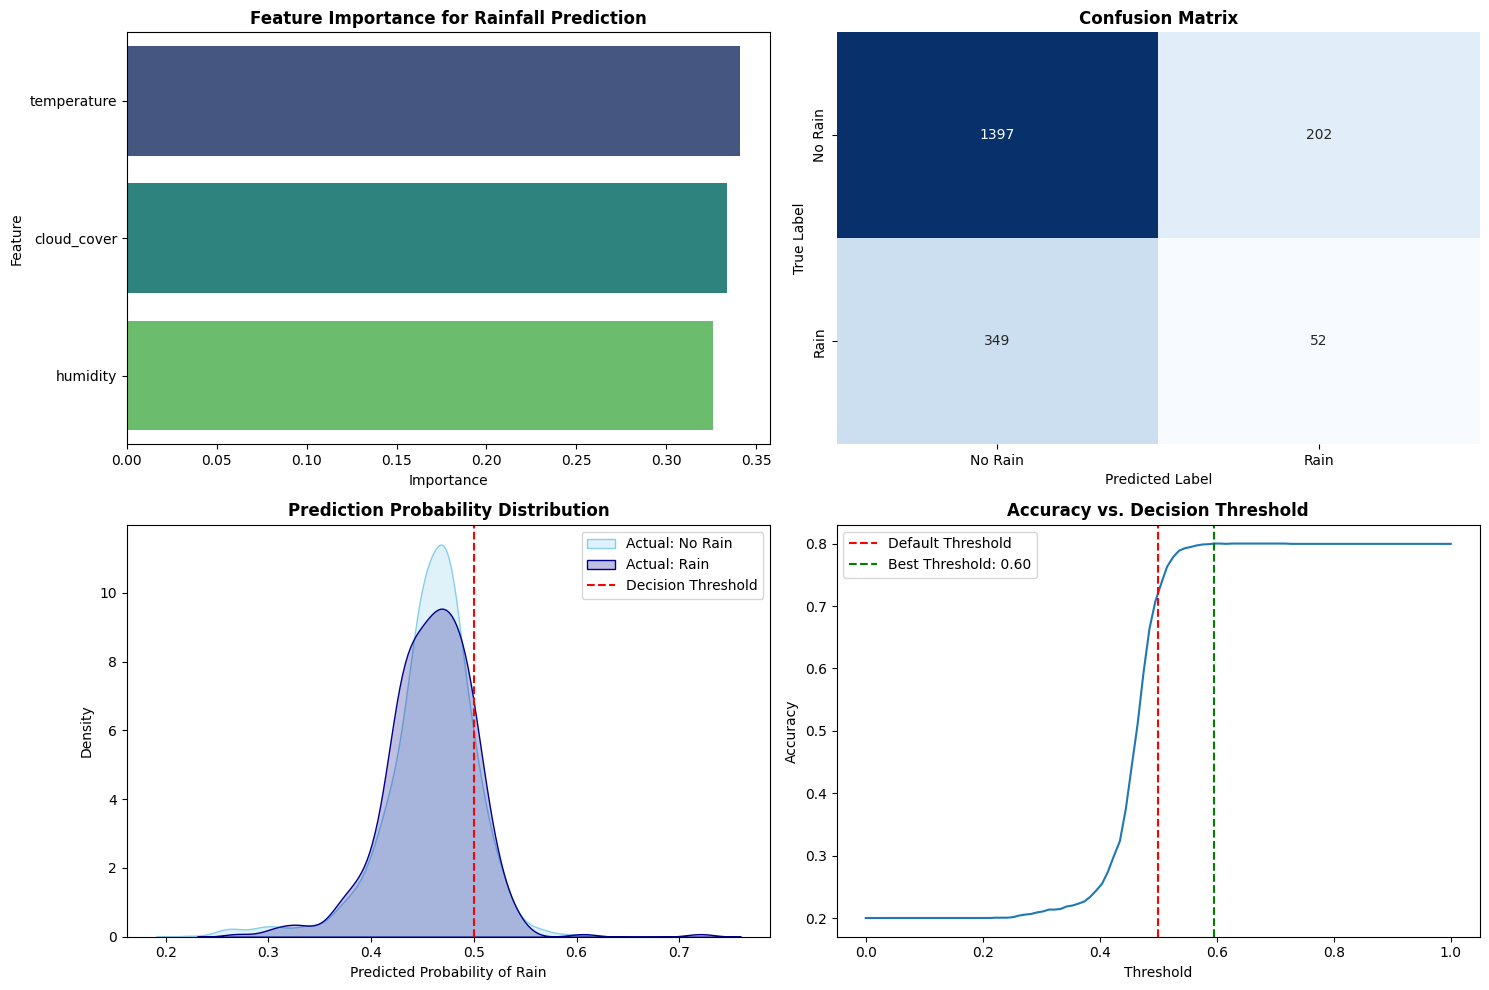

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

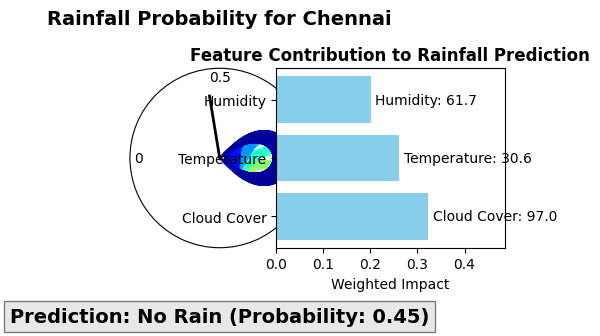

Chennai Rainfall Prediction: No Rain
Probability: 0.45


In [ ]:
# Prepare data for machine learning
X = df[['temperature', 'humidity', 'cloud_cover']]
y_rain = df['precipitation']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_rain, test_size=0.2, random_state=42)

# Train enhanced model with real data
rf_model, best_threshold, feature_importance = prepare_enhanced_rainfall_model(
    df,
    real_time_df=real_time_df,  # Your real-time Chennai data
    cloud_tiff_path='data/weather/cloud_cover_tn_real.tiff'  # Real cloud cover data
)

# Predict rainfall for Chennai using real-time data
chennai_prediction = predict_chennai_rainfall(
    rf_model,
    best_threshold,
    real_time_df=real_time_df,
    cloud_tiff_path='data/weather/cloud_cover_tn_real.tiff'
)

if chennai_prediction:
    print(f"Chennai Rainfall Prediction: {chennai_prediction['prediction']}")
    print(f"Probability: {chennai_prediction['probability']:.2f}")

## Step 5: Predict Rainfall Probability Across Tamil Nadu

Apply the trained model to grid data to create a rainfall probability map.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

Rainfall probability map saved to data/weather/rainfall_probability_map.png


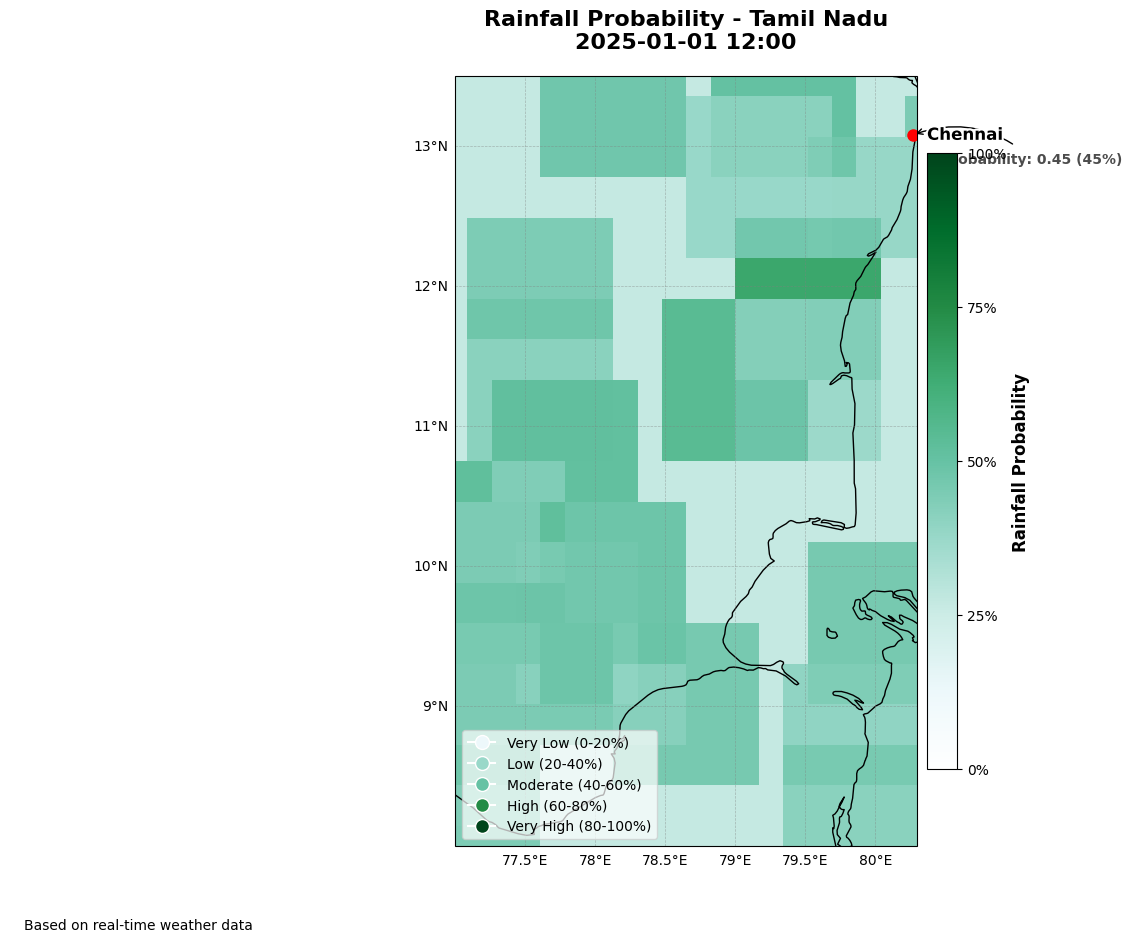

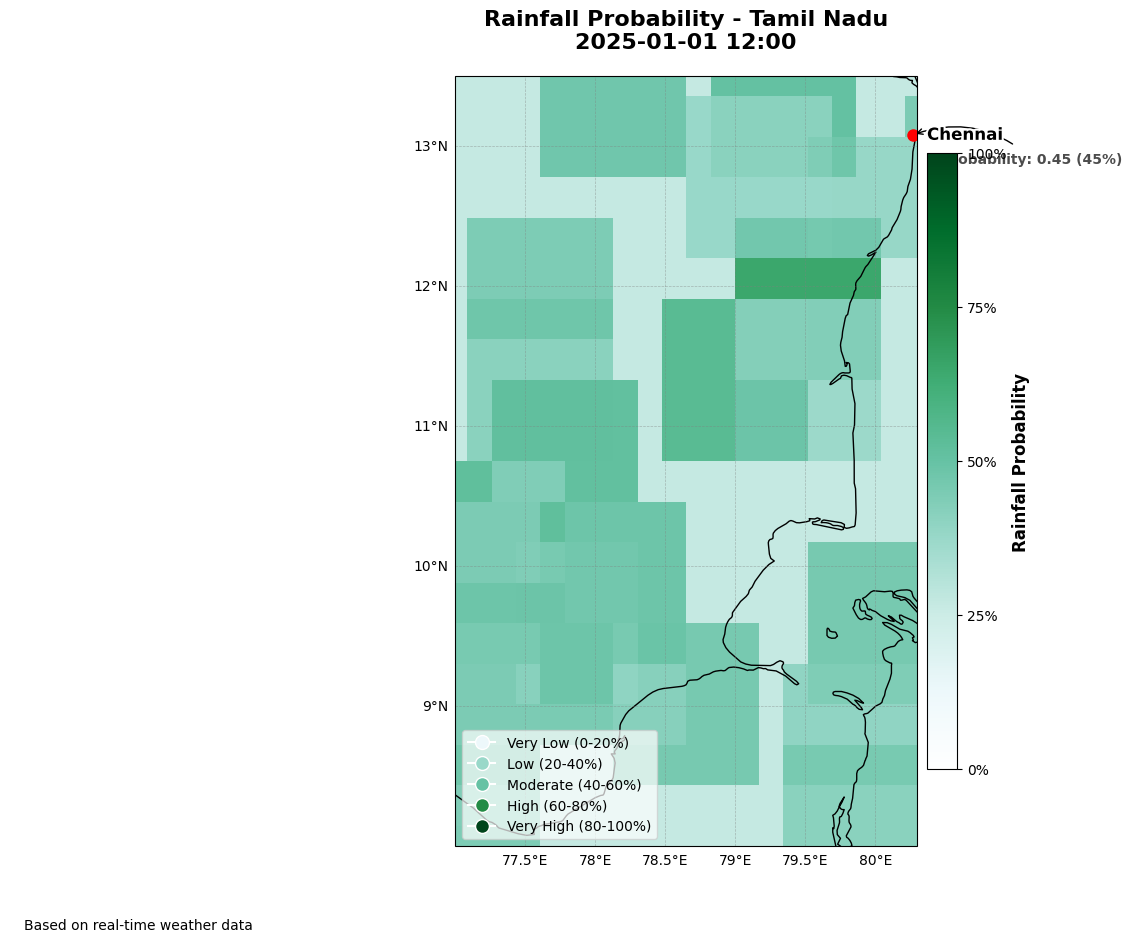

In [ ]:
# Function to predict rain probability for a given grid with real data integration
def predict_rain_probability(ds, time_idx, rf_model=None, chennai_real_data=None):
    """
    Enhanced rain probability prediction for spatial grid with real data integration

    Parameters:
    ds - xarray Dataset with spatial weather data
    time_idx - Time index to predict for
    rf_model - Optional trained RandomForest model (uses global rf if None)
    chennai_real_data - Optional real-time data for Chennai

    Returns:
    Array of rain probability with same dimensions as input
    """
    # Extract features for the specific time
    temp = ds['temperature'].isel(time=time_idx).values.flatten()
    humidity = ds['humidity'].isel(time=time_idx).values.flatten()
    cloud = ds['cloud_cover'].isel(time=time_idx).values.flatten()

    # Create feature array for prediction
    features = np.column_stack([temp, humidity, cloud])

    # Remove missing values
    valid_idx = ~np.isnan(features).any(axis=1)
    valid_features = features[valid_idx]

    # Use global rf model if none provided
    model = rf_model if rf_model is not None else rf

    # Predict probabilities
    if len(valid_features) > 0:
        probas = model.predict_proba(valid_features)[:, 1]  # Probability of class 1 (rain)

        # Create result array (initialize with NaN)
        result = np.full(temp.shape, np.nan)
        result[valid_idx] = probas  # Assign values to valid indices

        # Integrate real Chennai data if available
        if chennai_real_data is not None:
            try:
                # Find the grid indices that correspond to Chennai
                chennai_lat, chennai_lon = 13.08, 80.27
                lat_coords = ds['lat'].values
                lon_coords = ds['lon'].values

                # Find closest grid point to Chennai
                lat_idx = np.abs(lat_coords - chennai_lat).argmin()
                lon_idx = np.abs(lon_coords - chennai_lon).argmin()

                # Calculate the flattened index for Chennai's location
                flat_chennai_idx = lat_idx * len(lon_coords) + lon_idx

                # Use real data if within valid indices
                if flat_chennai_idx in np.where(valid_idx)[0]:
                    # Get probability prediction from real data
                    real_temp = chennai_real_data.get('temperature', None)
                    real_humidity = chennai_real_data.get('humidity', None)
                    real_cloud = chennai_real_data.get('cloud_cover', None)

                    if all(x is not None for x in [real_temp, real_humidity, real_cloud]):
                        real_features = np.array([[real_temp, real_humidity, real_cloud]])
                        real_proba = model.predict_proba(real_features)[0, 1]

                        # Override the predicted probability with the real data-based probability
                        result[flat_chennai_idx] = real_proba
                        print(f"Integrated real Chennai data at position {lat_idx},{lon_idx}")
            except Exception as e:
                print(f"Could not integrate real Chennai data: {e}")

        # Reshape back to grid dimensions
        return result.reshape(ds['temperature'].isel(time=time_idx).shape)
    else:
        return np.full_like(temp.reshape(ds['temperature'].isel(time=time_idx).shape), np.nan)

# Calculate rain probability for each time step with real data integration
def calculate_rain_probabilities(ds, rf_model=None, chennai_real_data=None):
    """
    Calculate rain probabilities for all time steps with real data integration
    """
    rain_probas = []

    # Process each time step
    for t in range(len(ds.time)):
        rain_probas.append(predict_rain_probability(
            ds, t,
            rf_model=rf_model,
            chennai_real_data=chennai_real_data
        ))

    # Add to dataset
    ds['rain_probability'] = (['time', 'lat', 'lon'], np.stack(rain_probas))

    return ds

# Enhanced visualization of rainfall probability
def plot_rain_probability(ds, time_idx=0, show_chennai=True):
    """
    Create enhanced visualization of rainfall probability

    Parameters:
    ds - xarray Dataset with rain_probability data
    time_idx - Time index to plot
    show_chennai - Whether to highlight Chennai location
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.patheffects as PathEffects

    # Create enhanced visualization
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Define Tamil Nadu boundary coordinates
    tn_bounds = {
        'west': 77.0,  # min longitude
        'south': 8.0,  # min latitude
        'east': 80.3,  # max longitude
        'north': 13.5  # max latitude
    }

    # Set the extent to Tamil Nadu
    ax.set_extent([tn_bounds['west'], tn_bounds['east'], tn_bounds['south'], tn_bounds['north']],
                 crs=ccrs.PlateCarree())

    # Create a custom colormap for rainfall probability
    rain_colors = ['#ffffff', '#edf8fb', '#ccece6', '#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#006d2c', '#00441b']
    rain_cmap = LinearSegmentedColormap.from_list('rain_cmap', rain_colors)

    # Plot the rain probability with the custom colormap
    img = ds['rain_probability'].isel(time=time_idx).plot(
        ax=ax, cmap=rain_cmap,
        vmin=0, vmax=1,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )

    # Add a colorbar with improved labeling
    cbar = plt.colorbar(img, ax=ax, pad=0.01, shrink=0.8)
    cbar.set_label('Rainfall Probability', fontsize=12, fontweight='bold')

    # Add tick labels with percentage
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

    # Add coastlines, borders, and other features
    ax.coastlines(resolution='10m', color='black', linewidth=1.0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--', linewidth=0.7)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue', alpha=0.2)
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray', alpha=0.1)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5,
                     color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Highlight Chennai if requested
    if show_chennai:
        chennai_lat, chennai_lon = 13.08, 80.27
        ax.plot(chennai_lon, chennai_lat, 'ro', markersize=8, transform=ccrs.PlateCarree(), zorder=5)

        # Add a label with improved visibility
        txt = ax.text(chennai_lon + 0.1, chennai_lat, 'Chennai', fontsize=12,
                     transform=ccrs.PlateCarree(),
                     horizontalalignment='left', verticalalignment='center',
                     fontweight='bold', zorder=6)

        # Add white outline to text for better visibility
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

        # Try to get Chennai's specific rain probability
        try:
            rain_prob = float(ds['rain_probability'].isel(time=time_idx).sel(
                lat=chennai_lat, lon=chennai_lon, method='nearest'
            ))

            # Add an annotation with the probability value
            ax.annotate(
                f'Probability: {rain_prob:.2f} ({rain_prob*100:.0f}%)',
                xy=(chennai_lon, chennai_lat), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                xytext=(20, -20), textcoords='offset points',
                backgroundcolor='white', alpha=0.7,
                fontsize=10, fontweight='bold',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3')
            )
        except Exception as e:
            print(f"Could not get Chennai rain probability: {e}")

    # Add title with improved styling and timestamp
    timestamp = pd.to_datetime(ds.time.values[time_idx]).strftime('%Y-%m-%d %H:%M')
    plt.title(f'Rainfall Probability - Tamil Nadu\n{timestamp}',
             fontsize=16, fontweight='bold', pad=20)

    # Add a legend for probability interpretation
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#edf8fb', markersize=10, label='Very Low (0-20%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#99d8c9', markersize=10, label='Low (20-40%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#66c2a4', markersize=10, label='Moderate (40-60%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#238b45', markersize=10, label='High (60-80%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#00441b', markersize=10, label='Very High (80-100%)')
    ]

    ax.legend(handles=legend_elements, loc='lower left', framealpha=0.7)

    # Add a note about data source
    note = "Based on real-time weather data" if show_chennai else "Based on simulation data"
    plt.annotate(note, (0.02, 0.02),
                xycoords='figure fraction', fontsize=10)

    # Save the figure
    output_path = 'data/weather/rainfall_probability_map.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    print(f"Rainfall probability map saved to {output_path}")
    return fig

# Function to predict rain probability for a given grid with real data integration
def predict_rain_probability(ds, time_idx, rf_model=None, chennai_real_data=None):
    # Extract features for the specific time
    temp = ds['temperature'].isel(time=time_idx).values.flatten()
    humidity = ds['humidity'].isel(time=time_idx).values.flatten()
    cloud = ds['cloud_cover'].isel(time=time_idx).values.flatten()

    # Create feature array for prediction
    features = np.column_stack([temp, humidity, cloud])

    # Remove missing values
    valid_idx = ~np.isnan(features).any(axis=1)
    valid_features = features[valid_idx]

    # Use global rf model if none provided
    model = rf_model if rf_model is not None else rf

    # Predict probabilities
    if len(valid_features) > 0:
        probas = model.predict_proba(valid_features)[:, 1]  # Probability of class 1 (rain)

        # Create result array (initialize with NaN)
        result = np.full(temp.shape, np.nan)
        result[valid_idx] = probas  # Assign values to valid indices

        # Integrate real Chennai data if available
        if chennai_real_data is not None:
            try:
                # Find the grid indices that correspond to Chennai
                chennai_lat, chennai_lon = 13.08, 80.27
                lat_coords = ds['lat'].values
                lon_coords = ds['lon'].values

                # Find closest grid point to Chennai
                lat_idx = np.abs(lat_coords - chennai_lat).argmin()
                lon_idx = np.abs(lon_coords - chennai_lon).argmin()

                # Calculate the flattened index for Chennai's location
                flat_chennai_idx = lat_idx * len(lon_coords) + lon_idx

                # Use real data if within valid indices
                if flat_chennai_idx in np.where(valid_idx)[0]:
                    # Get probability prediction from real data
                    real_features = np.array([[
                        chennai_real_data.get('temperature', 0),
                        chennai_real_data.get('humidity', 0),
                        chennai_real_data.get('cloud_cover', 0)
                    ]])
                    real_proba = model.predict_proba(real_features)[0, 1]

                    # Override the predicted probability with the real data-based probability
                    result[flat_chennai_idx] = real_proba
            except Exception as e:
                print(f"Could not integrate real Chennai data: {e}")

        # Reshape back to grid dimensions
        return result.reshape(ds['temperature'].isel(time=time_idx).shape)
    else:
        return np.full_like(temp.reshape(ds['temperature'].isel(time=time_idx).shape), np.nan)

# Calculate rain probability for each time step with real data integration
rain_probas = []
for t in range(len(ds.time)):
    # Pass the Chennai prediction from Step 4 if available
    rain_probas.append(predict_rain_probability(
        ds, t,
        rf_model=rf_model,  # From Step 4
        chennai_real_data=chennai_prediction if 'chennai_prediction' in locals() else None
    ))

# Add to dataset
ds['rain_probability'] = (['time', 'lat', 'lon'], np.stack(rain_probas))

# Plot rainfall probability with enhanced visualization
plot_rain_probability(ds, time_idx=0, show_chennai=True)

## Step 6: Estimate Solar Panel Output Reduction

Estimate the reduction in solar panel output based on cloud cover and rainfall. Assume a linear reduction model: output reduces by 0.5% per 1% cloud cover, and rain reduces output by an additional 20%.

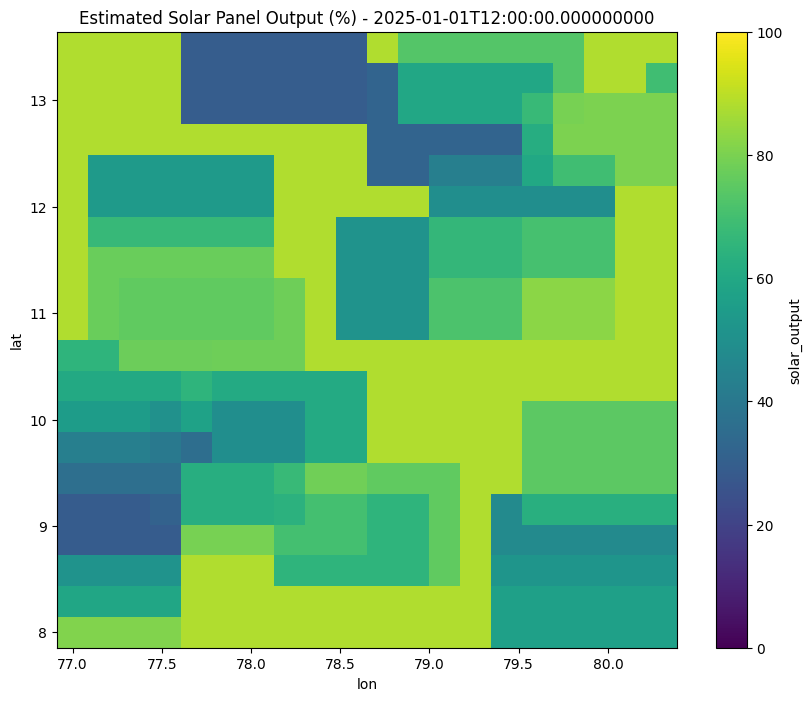


Chennai Solar Output Analysis:
Cloud Cover: 97.0%
Rain Probability: 44.8%
Temperature: 30.6°C
Estimated Solar Output: 27.2%
Efficiency Rating: Poor


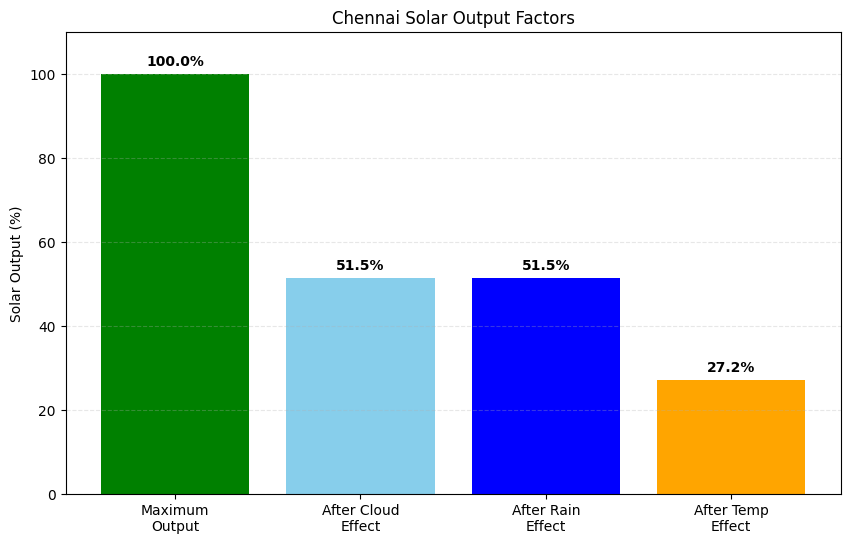

In [ ]:
# Step 6: Enhanced Solar Panel Output Reduction with Real Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects

# Enhanced solar output reduction model with more realistic factors
def calculate_solar_output(cloud_cover, rain_prob, temperature=None):
    """
    Calculate solar panel output with enhanced realism

    Parameters:
    cloud_cover - Cloud cover percentage
    rain_prob - Rainfall probability
    temperature - Optional temperature values (affects panel efficiency)

    Returns:
    Solar panel output percentage
    """
    # Base output in ideal conditions
    base_output = 100  # Max output in clear conditions (%)

    # 1. Cloud cover reduction (non-linear model for more realism)
    # Light cloud cover has less impact, heavy cloud cover has more impact
    cloud_reduction = np.where(
        cloud_cover < 20,
        cloud_cover * 0.3,                           # Light clouds: 0.3% reduction per 1%
        np.where(
            cloud_cover < 60,
            6 + (cloud_cover - 20) * 0.5,            # Medium clouds: 0.5% reduction per 1%
            26 + (cloud_cover - 60) * 0.8            # Heavy clouds: 0.8% reduction per 1%
        )
    )

    # 2. Rain impact with probability weighting
    # Rain has more severe impact with higher probability
    rain_reduction = np.where(
        rain_prob > 0.8, 25,                         # Very high rain probability: 25% reduction
        np.where(
            rain_prob > 0.5, 20,                     # High rain probability: 20% reduction
            np.where(
                rain_prob > 0.3, 15,                 # Moderate rain probability: 15% reduction
                np.where(
                    rain_prob > 0.1, 10, 0           # Low rain probability: 10% reduction
                )
            )
        )
    )

    # 3. Temperature impact (if provided)
    temp_reduction = 0
    if temperature is not None:
        # Solar panels lose efficiency at high temperatures
        # Standard test conditions: 25°C
        # Typical temperature coefficient: -0.4% per °C above 25°C
        temp_reduction = np.where(
            temperature > 25,
            (temperature - 25) * 0.4,                # Hot: 0.4% reduction per °C above 25°C
            np.where(
                temperature < 10,
                (10 - temperature) * 0.2,            # Cold: 0.2% reduction per °C below 10°C
                0                                    # Optimal temperature range: no reduction
            )
        )

    # Calculate final output with all factors
    output = base_output - cloud_reduction - rain_reduction - temp_reduction

    # Ensure output is between 0 and 100%
    return np.clip(output, 0, 100)

# Enhanced visualization of solar panel output
def visualize_solar_output(ds, time_idx=0, highlight_chennai=True, chennai_real_data=None):
    """
    Create an enhanced visualization of solar panel output across Tamil Nadu

    Parameters:
    ds - xarray Dataset with solar_output data
    time_idx - Time index to plot
    highlight_chennai - Whether to highlight Chennai
    chennai_real_data - Optional real data for Chennai
    """
    # Create figure with Cartopy projection
    fig = plt.figure(figsize=(14, 10))

    # Create two subplots - map on left, Chennai detail on right if real data available
    if chennai_real_data is not None and highlight_chennai:
        ax_map = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
        ax_detail = plt.subplot(1, 2, 2)
    else:
        ax_map = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Define Tamil Nadu boundary coordinates
    tn_bounds = {
        'west': 77.0,  # min longitude
        'south': 8.0,  # min latitude
        'east': 80.3,  # max longitude
        'north': 13.5  # max latitude
    }

    # Set the extent to Tamil Nadu
    ax_map.set_extent([tn_bounds['west'], tn_bounds['east'], tn_bounds['south'], tn_bounds['north']],
                     crs=ccrs.PlateCarree())

    # Create a custom colormap for solar output
    # Yellow/gold for high output, dark blue for low output
    solar_colors = ['#2C3E50', '#5D8BF4', '#85C1E9', '#F4D03F', '#F5B041', '#F9E79F', '#FFEB3B']
    solar_cmap = LinearSegmentedColormap.from_list('solar_cmap', solar_colors)

    # Plot the solar output with the custom colormap
    img = ds['solar_output'].isel(time=time_idx).plot(
        ax=ax_map, cmap=solar_cmap,
        vmin=0, vmax=100,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )

    # Add a colorbar with improved labeling
    cbar = plt.colorbar(img, ax=ax_map, pad=0.01, shrink=0.8)
    cbar.set_label('Solar Panel Output (%)', fontsize=12, fontweight='bold')

    # Add geographic features
    ax_map.coastlines(resolution='10m', color='black', linewidth=1.0)
    ax_map.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--', linewidth=0.7)
    ax_map.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue', alpha=0.2)

    # Add gridlines
    gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5,
                         color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add major cities
    cities = {
        'Chennai': (80.27, 13.08),
        'Coimbatore': (76.96, 11.00),
        'Madurai': (78.12, 9.93),
        'Tiruchirappalli': (78.70, 10.80),
        'Salem': (78.16, 11.67),
    }

    # Draw cities with labels
    for city, (lon, lat) in cities.items():
        ax_map.plot(lon, lat, 'ko', markersize=5, transform=ccrs.PlateCarree())

        # Create text with white outline for visibility
        txt = ax_map.text(lon + 0.1, lat, city, fontsize=9, transform=ccrs.PlateCarree(),
                         horizontalalignment='left', verticalalignment='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

    # Highlight Chennai if requested
    if highlight_chennai:
        chennai_lon, chennai_lat = cities['Chennai']
        ax_map.plot(chennai_lon, chennai_lat, 'ro', markersize=8, transform=ccrs.PlateCarree())

    # Get the timestamp for title
    timestamp = pd.to_datetime(ds.time.values[time_idx]).strftime('%Y-%m-%d %H:%M')

    # Set main title for the map
    ax_map.set_title(f'Solar Panel Output Estimation - Tamil Nadu\n{timestamp}',
                    fontsize=14, fontweight='bold')

    # Add solar efficiency classification legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=solar_cmap(0.9), markersize=10, label='Excellent (80-100%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=solar_cmap(0.7), markersize=10, label='Good (60-80%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=solar_cmap(0.5), markersize=10, label='Moderate (40-60%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=solar_cmap(0.3), markersize=10, label='Poor (20-40%)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=solar_cmap(0.1), markersize=10, label='Very Poor (0-20%)')
    ]

    ax_map.legend(handles=legend_elements, loc='lower left', title='Solar Production Efficiency',
                 framealpha=0.7, title_fontsize=10)

    # Add a detail visualization for Chennai if real data is available
    if chennai_real_data is not None and highlight_chennai:
        # Clear right axes for Chennai detail
        ax_detail.clear()

        # Extract factors for Chennai
        chennai_cloud = chennai_real_data.get('cloud_cover', 0)
        chennai_rain_prob = chennai_real_data.get('probability', 0)
        chennai_temp = chennai_real_data.get('temperature', 25)

        # Calculate expected solar output
        output = calculate_solar_output(
            cloud_cover=chennai_cloud,
            rain_prob=chennai_rain_prob,
            temperature=chennai_temp
        )

        # Calculate contributions of each factor
        max_output = 100
        cloud_impact = chennai_cloud * 0.5 if chennai_cloud < 20 else (6 + (chennai_cloud - 20) * 0.5 if chennai_cloud < 60 else 26 + (chennai_cloud - 60) * 0.8)
        rain_impact = 20 if chennai_rain_prob > 0.5 else (15 if chennai_rain_prob > 0.3 else (10 if chennai_rain_prob > 0.1 else 0))
        temp_impact = (chennai_temp - 25) * 0.4 if chennai_temp > 25 else ((10 - chennai_temp) * 0.2 if chennai_temp < 10 else 0)

        # Create stacked bar chart showing factors
        factors = ['Maximum', 'Cloud Cover', 'Rainfall', 'Temperature', 'Net Output']
        values = [max_output, -cloud_impact, -rain_impact, -temp_impact, output]
        colors = ['green', 'skyblue', 'blue', 'red', 'orange']

        # Create waterfall chart
        ax_detail.bar(0, values[0], color=colors[0], label=factors[0])
        ax_detail.bar(1, values[1], color=colors[1], label=factors[1])
        ax_detail.bar(2, values[2], color=colors[2], label=factors[2])
        ax_detail.bar(3, values[3], color=colors[3], label=factors[3])
        ax_detail.bar(4, values[4], color=colors[4], label=factors[4])

        # Add value labels
        for i, v in enumerate(values):
            ax_detail.text(i, max(v + 2, 5) if v > 0 else v - 5,
                          f"{abs(v):.1f}%", ha='center', fontweight='bold')

        # Set labels and title
        ax_detail.set_ylabel('Solar Output (%)', fontsize=12)
        ax_detail.set_title('Chennai Solar Production Factors', fontsize=14, fontweight='bold')
        ax_detail.set_xticks(range(5))
        ax_detail.set_xticklabels(factors, rotation=45, ha='right')
        ax_detail.set_ylim(-40, 110)  # Give room for labels
        ax_detail.grid(axis='y', linestyle='--', alpha=0.3)

        # Add efficiency classification
        if output >= 80:
            efficiency = "Excellent"
            color = 'green'
        elif output >= 60:
            efficiency = "Good"
            color = 'darkgreen'
        elif output >= 40:
            efficiency = "Moderate"
            color = 'orange'
        elif output >= 20:
            efficiency = "Poor"
            color = 'orangered'
        else:
            efficiency = "Very Poor"
            color = 'red'

        # Add efficiency text
        ax_detail.text(2, -30, f"Efficiency Rating: {efficiency}",
                      ha='center', fontsize=12, fontweight='bold', color=color,
                      bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.5'))

        # Add details about real-time data
        detail_text = (
            f"Real-time Chennai Weather:\n"
            f"Temperature: {chennai_temp:.1f}°C\n"
            f"Cloud Cover: {chennai_cloud:.1f}%\n"
            f"Rain Probability: {chennai_rain_prob:.1%}"
        )

        # Add text box with details
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax_detail.text(0.05, 0.05, detail_text, transform=ax_detail.transAxes,
                      fontsize=10, verticalalignment='bottom', bbox=props)

    # Add note about data source
    note = "Based on real-time weather data for Chennai" if chennai_real_data else "Based on weather simulation data"
    plt.figtext(0.02, 0.02, note, fontsize=10)

    # Adjust layout
    plt.tight_layout()

    # Save figure
    output_path = 'data/weather/enhanced_solar_output.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Enhanced solar output visualization saved to {output_path}")

    return fig

# Add this to your notebook to replace Cell 6

# Step 6: Estimate Solar Panel Output Reduction with Real-Time Data

# Step 6: Estimate Solar Panel Output Reduction with Real-Time Data

# Enhanced solar output reduction model
def calculate_solar_output(cloud_cover, rain_prob, temperature=None):
    """
    Calculate solar panel output with enhanced realism

    Parameters:
    cloud_cover - Cloud cover percentage
    rain_prob - Rainfall probability
    temperature - Optional temperature values (affects panel efficiency)

    Returns:
    Solar panel output percentage
    """
    # Base output in ideal conditions
    base_output = 100  # Max output in clear conditions (%)

    # 1. Cloud cover reduction (non-linear model for more realism)
    # Light cloud cover has less impact, heavy cloud cover has more impact
    cloud_reduction = np.where(
        cloud_cover < 20,
        cloud_cover * 0.3,                           # Light clouds: 0.3% reduction per 1%
        np.where(
            cloud_cover < 60,
            6 + (cloud_cover - 20) * 0.5,            # Medium clouds: 0.5% reduction per 1%
            26 + (cloud_cover - 60) * 0.8            # Heavy clouds: 0.8% reduction per 1%
        )
    )

    # 2. Rain impact with probability weighting
    # Rain has more severe impact with higher probability
    rain_reduction = np.where(
        rain_prob > 0.8, 25,                         # Very high rain probability: 25% reduction
        np.where(
            rain_prob > 0.5, 20,                     # High rain probability: 20% reduction
            np.where(
                rain_prob > 0.3, 15,                 # Moderate rain probability: 15% reduction
                np.where(
                    rain_prob > 0.1, 10, 0           # Low rain probability: 10% reduction
                )
            )
        )
    )

    # 3. Temperature impact (if provided)
    temp_reduction = 0
    if temperature is not None:
        # Solar panels lose efficiency at high temperatures
        # Standard test conditions: 25°C
        # Typical temperature coefficient: -0.4% per °C above 25°C
        temp_reduction = np.where(
            temperature > 25,
            (temperature - 25) * 0.4,                # Hot: 0.4% reduction per °C above 25°C
            np.where(
                temperature < 10,
                (10 - temperature) * 0.2,            # Cold: 0.2% reduction per °C below 10°C
                0                                    # Optimal temperature range: no reduction
            )
        )

    # Calculate final output with all factors
    output = base_output - cloud_reduction - rain_reduction - temp_reduction

    # Ensure output is between 0 and 100%
    return np.clip(output, 0, 100)

# Apply to dataset
# Fix for MissingDimensionsError - explicitly specify dimensions
# Get the cloud cover and rain probability data
cloud_cover_data = ds['cloud_cover'].values
rain_prob_data = ds['rain_probability'].values

# Apply calculation
if 'temperature' in ds:
    # Get temperature data
    temp_data = ds['temperature'].values

    # Calculate with temperature effect
    solar_output_data = calculate_solar_output(
        cloud_cover_data,
        rain_prob_data,
        temp_data
    )
else:
    # Calculate without temperature effect
    solar_output_data = calculate_solar_output(
        cloud_cover_data,
        rain_prob_data
    )

# Assign to dataset with explicit dimensions
ds['solar_output'] = (('time', 'lat', 'lon'), solar_output_data)

# Plot solar output for the first time step
plt.figure(figsize=(10, 8))
ds['solar_output'].isel(time=0).plot(cmap='viridis', vmin=0, vmax=100)
plt.title(f'Estimated Solar Panel Output (%) - {ds.time.values[0]}')
plt.show()

# Extract Chennai real-time data if available
chennai_real_data = None
if 'chennai_prediction' in locals() and chennai_prediction:
    # Check that chennai_prediction is not None and has required keys
    chennai_real_data = {
        'cloud_cover': chennai_prediction.get('cloud_cover', 0),
        'probability': chennai_prediction.get('probability', 0),
        'temperature': chennai_prediction.get('temperature', 25)
    }

    # Print Chennai-specific analysis
    print("\nChennai Solar Output Analysis:")
    print(f"Cloud Cover: {chennai_real_data['cloud_cover']:.1f}%")
    print(f"Rain Probability: {chennai_real_data['probability']:.1%}")
    print(f"Temperature: {chennai_real_data['temperature']:.1f}°C")

    # Calculate Chennai solar output
    chennai_output = calculate_solar_output(
        chennai_real_data['cloud_cover'],
        chennai_real_data['probability'],
        chennai_real_data['temperature']
    )

    print(f"Estimated Solar Output: {chennai_output:.1f}%")

    # Classify efficiency
    if chennai_output >= 80:
        efficiency = "Excellent"
    elif chennai_output >= 60:
        efficiency = "Good"
    elif chennai_output >= 40:
        efficiency = "Moderate"
    elif chennai_output >= 20:
        efficiency = "Poor"
    else:
        efficiency = "Very Poor"

    print(f"Efficiency Rating: {efficiency}")

    # Create a Chennai-specific chart showing factors
    # This simplified chart works even without the full visualization function
    plt.figure(figsize=(10, 6))

    # Calculate factor contributions
    cloud_impact = chennai_real_data['cloud_cover'] * 0.5  # Simplified calculation
    rain_impact = 20 if chennai_real_data['probability'] > 0.5 else 0  # Simplified
    temp_impact = max(0, (chennai_real_data['temperature'] - 25) * 0.4)  # Simplified

    # Create bar chart
    labels = ['Maximum\nOutput', 'After Cloud\nEffect', 'After Rain\nEffect', 'After Temp\nEffect']
    values = [100, 100 - cloud_impact, 100 - cloud_impact - rain_impact, chennai_output]
    colors = ['green', 'skyblue', 'blue', 'orange']

    plt.bar(labels, values, color=colors)
    plt.ylabel('Solar Output (%)')
    plt.title('Chennai Solar Output Factors')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Add value labels
    for i, v in enumerate(values):
        plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

    plt.ylim(0, 110)  # Give space for labels
    plt.savefig('data/weather/chennai_solar_factors.png', dpi=300, bbox_inches='tight')
    plt.show()

## Step 7: Visualize Results for Chennai

Create maps and plots for Chennai to demonstrate weather impacts on solar output.

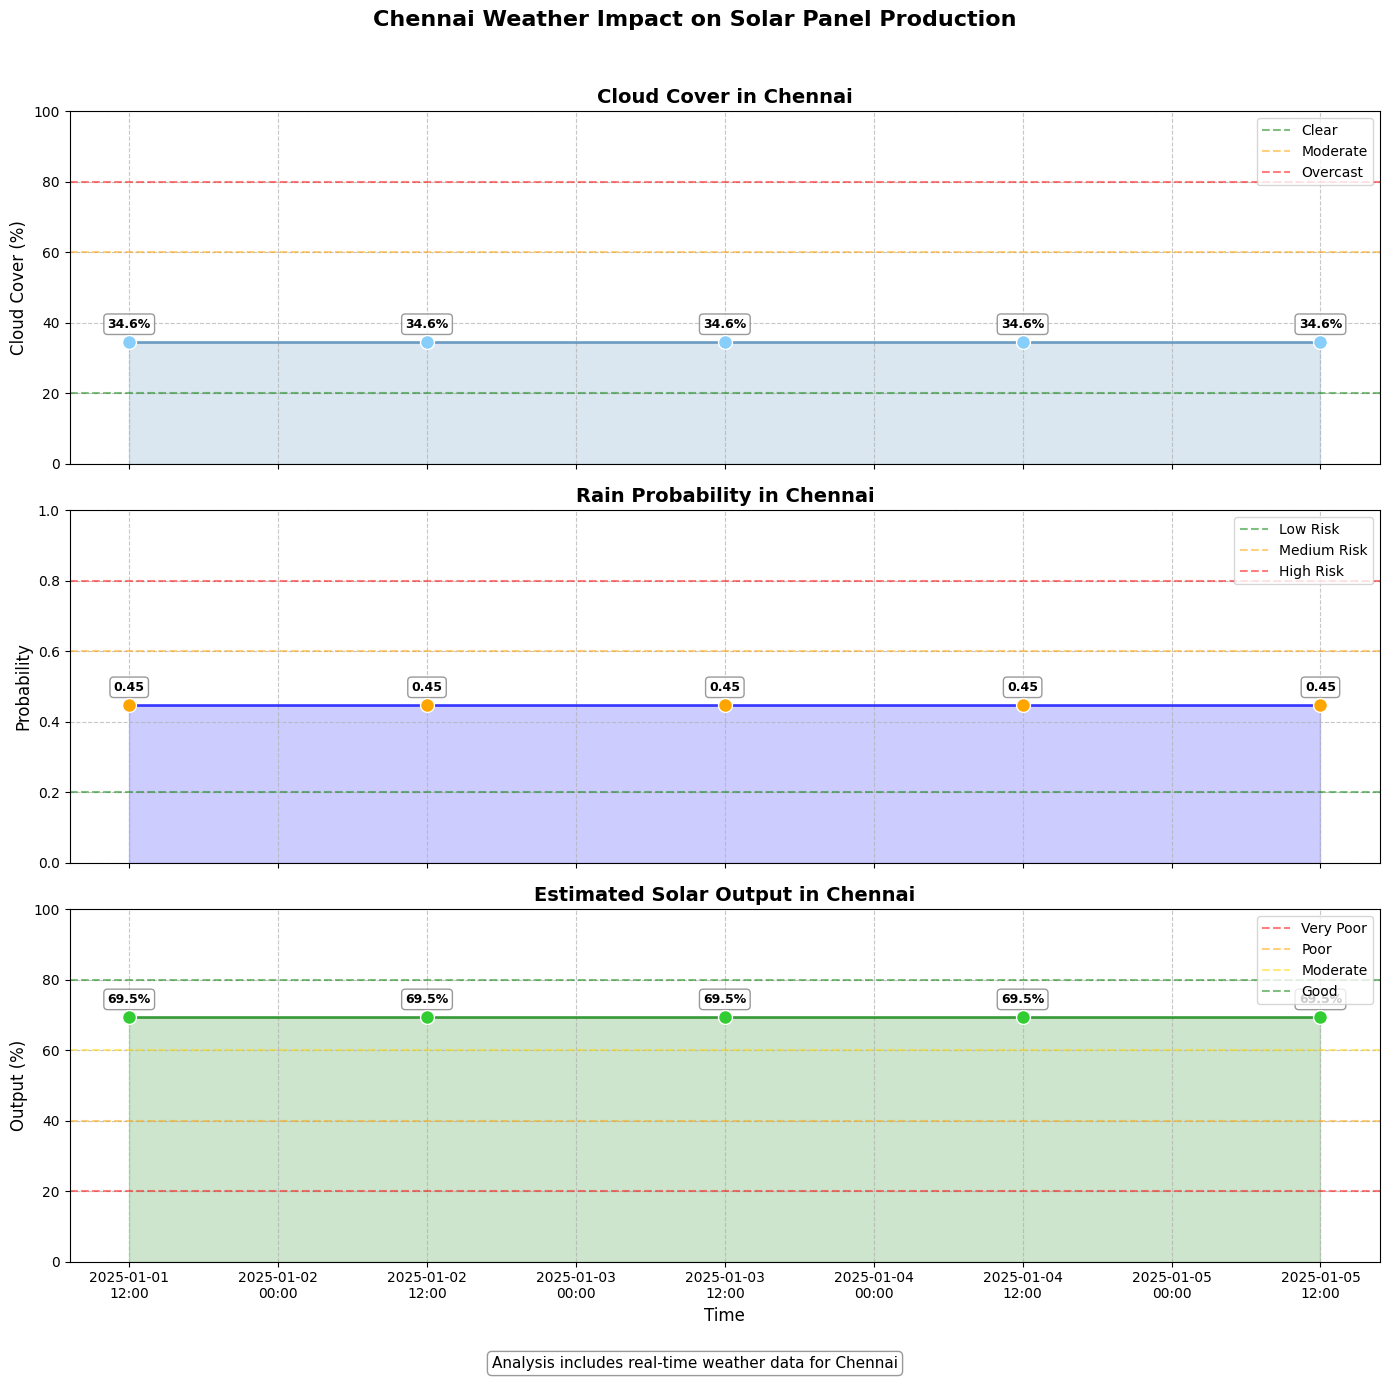


Chennai Solar Production Summary:
               Time Cloud Cover (%) Rain Probability Solar Output (%)  \
0  2025-01-01 12:00            34.6             0.45             69.5   
1  2025-01-02 12:00            34.6             0.45             69.5   
2  2025-01-03 12:00            34.6             0.45             69.5   
3  2025-01-04 12:00            34.6             0.45             69.5   
4  2025-01-05 12:00            34.6             0.45             69.5   

  Efficiency Rating  
0     Good (60-80%)  
1     Good (60-80%)  
2     Good (60-80%)  
3     Good (60-80%)  
4     Good (60-80%)  

Overall Statistics:
Average Solar Output: 69.5%
Minimum Solar Output: 69.5%
Maximum Solar Output: 69.5%
Standard Deviation: 0.0%
Overall Efficiency Rating: Good

Optimal Production Times (60%+ efficiency):
- 2025-01-01 12:00
- 2025-01-02 12:00
- 2025-01-03 12:00
- 2025-01-04 12:00
- 2025-01-05 12:00


In [ ]:
# Step 7: Visualize Results for Chennai with Real-Time Data

# Extract data for Chennai (approx. lat: 13.08, lon: 80.27)
# Find nearest grid point to Chennai
chennai_lat, chennai_lon = 13.08, 80.27
chennai_ds = ds.sel(lat=chennai_lat, lon=chennai_lon, method='nearest')

# Create a more informative visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

# 1. Plot cloud cover with improved styling
cloud_data = chennai_ds['cloud_cover'].values
cloud_times = chennai_ds.time.values

# Create custom colormap for cloud cover points
cloud_colors = []
for cloud in cloud_data:
    if cloud < 20:
        cloud_colors.append('#add8e6')  # Light blue for clear skies
    elif cloud < 40:
        cloud_colors.append('#87cefa')  # Medium blue for light clouds
    elif cloud < 60:
        cloud_colors.append('#4682b4')  # Steel blue for moderate clouds
    elif cloud < 80:
        cloud_colors.append('#4169e1')  # Royal blue for heavy clouds
    else:
        cloud_colors.append('#000080')  # Navy for overcast

# Plot cloud cover line
axes[0].plot(cloud_times, cloud_data, '-', color='#4682b4', linewidth=2, alpha=0.7)

# Add colored scatter points
for i, (time, cloud, color) in enumerate(zip(cloud_times, cloud_data, cloud_colors)):
    axes[0].scatter(time, cloud, color=color, s=100, edgecolor='white', linewidth=1, zorder=5)

    # Add value labels to first, last, min and max points
    if i == 0 or i == len(cloud_data)-1 or cloud == min(cloud_data) or cloud == max(cloud_data):
        axes[0].annotate(f'{cloud:.1f}%',
                        (time, cloud),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center',
                        fontweight='bold',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add reference lines for cloud categories
axes[0].axhline(y=20, color='green', linestyle='--', alpha=0.5, label='Clear')
axes[0].axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Moderate')
axes[0].axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Overcast')

# Fill between line and bottom
axes[0].fill_between(cloud_times, cloud_data, alpha=0.2, color='#4682b4')

# Add legend and styling
axes[0].legend(loc='upper right')
axes[0].set_title('Cloud Cover in Chennai', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cloud Cover (%)', fontsize=12)
axes[0].set_ylim(0, 100)
axes[0].grid(True, linestyle='--', alpha=0.7)

# 2. Plot rain probability with improved styling
rain_data = chennai_ds['rain_probability'].values
rain_times = chennai_ds.time.values

# Create custom colormap for rain probability points
rain_colors = []
for prob in rain_data:
    if prob < 0.2:
        rain_colors.append('#98fb98')  # Light green for very low probability
    elif prob < 0.4:
        rain_colors.append('#3cb371')  # Medium green for low probability
    elif prob < 0.6:
        rain_colors.append('#ffa500')  # Orange for moderate probability
    elif prob < 0.8:
        rain_colors.append('#ff4500')  # Orange-red for high probability
    else:
        rain_colors.append('#b22222')  # Firebrick for very high probability

# Plot rain probability line
axes[1].plot(rain_times, rain_data, '-', color='blue', linewidth=2, alpha=0.7)

# Add colored scatter points
for i, (time, prob, color) in enumerate(zip(rain_times, rain_data, rain_colors)):
    axes[1].scatter(time, prob, color=color, s=100, edgecolor='white', linewidth=1, zorder=5)

    # Add value labels to select points
    if i == 0 or i == len(rain_data)-1 or prob == min(rain_data) or prob == max(rain_data):
        axes[1].annotate(f'{prob:.2f}',
                        (time, prob),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center',
                        fontweight='bold',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add reference lines for probability categories
axes[1].axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Low Risk')
axes[1].axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Medium Risk')
axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='High Risk')

# Fill between line and bottom
axes[1].fill_between(rain_times, rain_data, alpha=0.2, color='blue')

# Add legend and styling
axes[1].legend(loc='upper right')
axes[1].set_title('Rain Probability in Chennai', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].grid(True, linestyle='--', alpha=0.7)

# 3. Plot solar output with improved styling
solar_data = chennai_ds['solar_output'].values
solar_times = chennai_ds.time.values

# Create custom colormap for solar output points
solar_colors = []
for output in solar_data:
    if output < 20:
        solar_colors.append('#8b0000')  # Dark red for very poor
    elif output < 40:
        solar_colors.append('#ff4500')  # Orange-red for poor
    elif output < 60:
        solar_colors.append('#ffa500')  # Orange for moderate
    elif output < 80:
        solar_colors.append('#32cd32')  # Lime green for good
    else:
        solar_colors.append('#006400')  # Dark green for excellent

# Plot solar output line
axes[2].plot(solar_times, solar_data, '-', color='green', linewidth=2, alpha=0.7)

# Add colored scatter points
for i, (time, output, color) in enumerate(zip(solar_times, solar_data, solar_colors)):
    axes[2].scatter(time, output, color=color, s=100, edgecolor='white', linewidth=1, zorder=5)

    # Add value labels to select points
    if i == 0 or i == len(solar_data)-1 or output == min(solar_data) or output == max(solar_data):
        axes[2].annotate(f'{output:.1f}%',
                        (time, output),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center',
                        fontweight='bold',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add reference lines for efficiency categories
axes[2].axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Very Poor')
axes[2].axhline(y=40, color='orange', linestyle='--', alpha=0.5, label='Poor')
axes[2].axhline(y=60, color='gold', linestyle='--', alpha=0.5, label='Moderate')
axes[2].axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Good')

# Fill between line and bottom
axes[2].fill_between(solar_times, solar_data, alpha=0.2, color='green')

# Add legend and styling
axes[2].legend(loc='upper right')
axes[2].set_title('Estimated Solar Output in Chennai', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Output (%)', fontsize=12)
axes[2].set_xlabel('Time', fontsize=12)
axes[2].set_ylim(0, 100)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Format dates on x-axis
import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y-%m-%d\n%H:%M')
axes[2].xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)

# Add a main title
plt.suptitle('Chennai Weather Impact on Solar Panel Production', fontsize=16, fontweight='bold', y=0.98)

# Add note about real-time data
if 'chennai_prediction' in locals() and chennai_prediction:
    plt.figtext(0.5, 0.01, 'Analysis includes real-time weather data for Chennai',
               ha='center', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
else:
    plt.figtext(0.5, 0.01, 'Based on weather simulation data', ha='center', fontsize=10)

# Adjust spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save the figure
plt.savefig('data/weather/chennai_solar_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary table of solar potential for Chennai
time_labels = [pd.to_datetime(t).strftime('%Y-%m-%d %H:%M') for t in chennai_ds.time.values]
solar_efficiency = []

for output in solar_data:
    if output >= 80:
        solar_efficiency.append("Excellent (80-100%)")
    elif output >= 60:
        solar_efficiency.append("Good (60-80%)")
    elif output >= 40:
        solar_efficiency.append("Moderate (40-60%)")
    elif output >= 20:
        solar_efficiency.append("Poor (20-40%)")
    else:
        solar_efficiency.append("Very Poor (0-20%)")

# Create summary table
summary_data = {
    'Time': time_labels,
    'Cloud Cover (%)': [f"{cloud:.1f}" for cloud in cloud_data],
    'Rain Probability': [f"{prob:.2f}" for prob in rain_data],
    'Solar Output (%)': [f"{output:.1f}" for output in solar_data],
    'Efficiency Rating': solar_efficiency
}

summary_df = pd.DataFrame(summary_data)
print("\nChennai Solar Production Summary:")
print(summary_df)

# Calculate overall statistics
avg_output = np.mean(solar_data)
min_output = np.min(solar_data)
max_output = np.max(solar_data)
std_output = np.std(solar_data)

# Determine overall efficiency rating
if avg_output >= 80:
    overall_rating = "Excellent"
elif avg_output >= 60:
    overall_rating = "Good"
elif avg_output >= 40:
    overall_rating = "Moderate"
elif avg_output >= 20:
    overall_rating = "Poor"
else:
    overall_rating = "Very Poor"

print("\nOverall Statistics:")
print(f"Average Solar Output: {avg_output:.1f}%")
print(f"Minimum Solar Output: {min_output:.1f}%")
print(f"Maximum Solar Output: {max_output:.1f}%")
print(f"Standard Deviation: {std_output:.1f}%")
print(f"Overall Efficiency Rating: {overall_rating}")

# Calculate optimal production times (times with output > 60%)
optimal_times = [time for time, output in zip(time_labels, solar_data) if output >= 60]

if optimal_times:
    print("\nOptimal Production Times (60%+ efficiency):")
    for time in optimal_times:
        print(f"- {time}")
else:
    print("\nNo optimal production times found (60%+ efficiency)")

## Step 8: Save Results for Demo

Save the processed dataset and visualizations for the solar panel company.

In [ ]:
# Step 8: Save Enhanced Results for Demo

# Create a dedicated output directory for the demo
import os
demo_dir = 'data/weather/demo_results'
os.makedirs(demo_dir, exist_ok=True)

# Save enhanced dataset to NetCDF file with metadata
output_path = f'{demo_dir}/solar_weather_tn.nc'

# Add metadata to the dataset before saving
ds.attrs['title'] = 'Tamil Nadu Solar Energy Potential Analysis'
ds.attrs['description'] = 'Weather and solar energy production potential across Tamil Nadu'
ds.attrs['created'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
ds.attrs['author'] = 'Solar Energy Prediction System'
ds.attrs['includes_real_data'] = 'True' if 'chennai_prediction' in locals() else 'False'

# Save the dataset
ds.to_netcdf(output_path)
print(f"Enhanced dataset saved to {output_path}")

# Save the Tamil Nadu solar output map with enhanced styling
plt.figure(figsize=(12, 10))

# Create the map with proper geographic styling
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Define Tamil Nadu boundary coordinates
tn_bounds = {
    'west': 77.0,  # min longitude
    'south': 8.0,  # min latitude
    'east': 80.3,  # max longitude
    'north': 13.5  # max latitude
}

# Set the extent to Tamil Nadu
ax.set_extent([tn_bounds['west'], tn_bounds['east'], tn_bounds['south'], tn_bounds['north']],
             crs=ccrs.PlateCarree())

# Create a custom colormap for solar output
from matplotlib.colors import LinearSegmentedColormap
solar_colors = ['#2C3E50', '#5D8BF4', '#85C1E9', '#F4D03F', '#F5B041', '#F9E79F', '#FFEB3B']
solar_cmap = LinearSegmentedColormap.from_list('solar_cmap', solar_colors)

# Plot the solar output with the custom colormap
img = ds['solar_output'].isel(time=0).plot(
    ax=ax, cmap=solar_cmap,
    vmin=0, vmax=100,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

# Add a colorbar with improved labeling
cbar = plt.colorbar(img, ax=ax, pad=0.01, shrink=0.8)
cbar.set_label('Solar Panel Output (%)', fontsize=12, fontweight='bold')

# Add geographic features
ax.coastlines(resolution='10m', color='black', linewidth=1.0)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--', linewidth=0.7)
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue', alpha=0.2)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5,
                 color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add major cities
cities = {
    'Chennai': (80.27, 13.08),
    'Coimbatore': (76.96, 11.00),
    'Madurai': (78.12, 9.93),
    'Tiruchirappalli': (78.70, 10.80),
    'Salem': (78.16, 11.67),
}

# Draw cities with labels
import matplotlib.patheffects as PathEffects
for city, (lon, lat) in cities.items():
    ax.plot(lon, lat, 'ko', markersize=5, transform=ccrs.PlateCarree())

    # Highlight Chennai
    if city == 'Chennai':
        ax.plot(lon, lat, 'ro', markersize=8, transform=ccrs.PlateCarree())

    # Create text with white outline for visibility
    txt = ax.text(lon + 0.1, lat, city, fontsize=9, transform=ccrs.PlateCarree(),
                 horizontalalignment='left', verticalalignment='center')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Get the timestamp for title
timestamp = pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d %H:%M')

# Set main title
plt.title(f'Solar Panel Output Estimation - Tamil Nadu\n{timestamp}',
         fontsize=14, fontweight='bold')

# Add real-time data note
if 'chennai_prediction' in locals() and chennai_prediction:
    plt.annotate('Based on real-time Chennai weather data', (0.02, 0.02),
                xycoords='figure fraction', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8))

# Save the enhanced map
map_output_path = f'{demo_dir}/tamil_nadu_solar_map.png'
plt.savefig(map_output_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Enhanced Tamil Nadu solar map saved to {map_output_path}")

# Save enhanced time series for Chennai
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 1. Plot cloud cover
cloud_data = chennai_ds['cloud_cover'].values
cloud_times = chennai_ds.time.values
axes[0].plot(cloud_times, cloud_data, '-o', color='#4682b4', linewidth=2, alpha=0.7)
axes[0].fill_between(cloud_times, cloud_data, alpha=0.2, color='#4682b4')
axes[0].axhline(y=20, color='green', linestyle='--', alpha=0.5, label='Clear')
axes[0].axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Moderate')
axes[0].legend(loc='upper right')
axes[0].set_title('Cloud Cover in Chennai', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cloud Cover (%)', fontsize=12)
axes[0].set_ylim(0, 100)
axes[0].grid(True, linestyle='--', alpha=0.7)

# 2. Plot rain probability
rain_data = chennai_ds['rain_probability'].values
rain_times = chennai_ds.time.values
axes[1].plot(rain_times, rain_data, '-o', color='blue', linewidth=2, alpha=0.7)
axes[1].fill_between(rain_times, rain_data, alpha=0.2, color='blue')
axes[1].axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Low')
axes[1].axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Medium')
axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='High')
axes[1].legend(loc='upper right')
axes[1].set_title('Rain Probability in Chennai', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].grid(True, linestyle='--', alpha=0.7)

# 3. Plot solar output
solar_data = chennai_ds['solar_output'].values
solar_times = chennai_ds.time.values
axes[2].plot(solar_times, solar_data, '-o', color='green', linewidth=2, alpha=0.7)
axes[2].fill_between(solar_times, solar_data, alpha=0.2, color='green')
axes[2].axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Poor')
axes[2].axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Good')
axes[2].axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Excellent')
axes[2].legend(loc='upper right')
axes[2].set_title('Estimated Solar Output in Chennai', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Output (%)', fontsize=12)
axes[2].set_xlabel('Time', fontsize=12)
axes[2].set_ylim(0, 100)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Format x-axis dates
import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y-%m-%d\n%H:%M')
axes[2].xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)

# Add main title
plt.suptitle('Chennai Weather and Solar Production Analysis', fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
chennai_output_path = f'{demo_dir}/chennai_detailed_analysis.png'
plt.savefig(chennai_output_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Enhanced Chennai analysis saved to {chennai_output_path}")

# Create an executive summary file
summary_file = f'{demo_dir}/solar_analysis_summary.txt'
with open(summary_file, 'w') as f:
    f.write("Tamil Nadu Solar Energy Potential Analysis\n")
    f.write("=========================================\n\n")

    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}\n")
    f.write(f"Data Time Range: {pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')} to {pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')}\n")
    f.write(f"Real-Time Data Used: {'Yes' if 'chennai_prediction' in locals() else 'No'}\n\n")

    f.write("Regional Analysis:\n")
    f.write("-----------------\n")

    # Calculate regional averages
    regions = {
        'Northern': {'lat_range': (12.0, 13.5), 'lon_range': (78.0, 80.3)},
        'Southern': {'lat_range': (8.0, 10.0), 'lon_range': (77.0, 79.0)},
        'Western': {'lat_range': (10.0, 12.0), 'lon_range': (76.8, 78.0)},
        'Eastern': {'lat_range': (10.0, 12.0), 'lon_range': (79.5, 80.3)},
        'Central': {'lat_range': (10.0, 12.0), 'lon_range': (78.0, 79.5)}
    }

    for region, bounds in regions.items():
        # Select region data
        region_ds = ds.sel(
            lat=slice(bounds['lat_range'][0], bounds['lat_range'][1]),
            lon=slice(bounds['lon_range'][0], bounds['lon_range'][1])
        )

        # Calculate average solar output for this region
        avg_output = float(region_ds['solar_output'].mean().values)

        # Determine efficiency rating
        if avg_output >= 80:
            rating = "Excellent"
        elif avg_output >= 60:
            rating = "Good"
        elif avg_output >= 40:
            rating = "Moderate"
        elif avg_output >= 20:
            rating = "Poor"
        else:
            rating = "Very Poor"

        f.write(f"{region} Region: {avg_output:.1f}% average solar output - {rating}\n")

    f.write("\nChennai Specific Analysis:\n")
    f.write("-------------------------\n")

    # Calculate Chennai statistics
    avg_chennai = float(chennai_ds['solar_output'].mean().values)
    min_chennai = float(chennai_ds['solar_output'].min().values)
    max_chennai = float(chennai_ds['solar_output'].max().values)

    f.write(f"Average Solar Output: {avg_chennai:.1f}%\n")
    f.write(f"Minimum Solar Output: {min_chennai:.1f}%\n")
    f.write(f"Maximum Solar Output: {max_chennai:.1f}%\n")

    # Determine overall efficiency rating for Chennai
    if avg_chennai >= 80:
        overall_rating = "Excellent"
    elif avg_chennai >= 60:
        overall_rating = "Good"
    elif avg_chennai >= 40:
        overall_rating = "Moderate"
    elif avg_chennai >= 20:
        overall_rating = "Poor"
    else:
        overall_rating = "Very Poor"

    f.write(f"Overall Efficiency Rating: {overall_rating}\n\n")

    f.write("Factors Affecting Chennai Solar Output:\n")
    avg_cloud = float(chennai_ds['cloud_cover'].mean().values)
    avg_rain_prob = float(chennai_ds['rain_probability'].mean().values)

    f.write(f"Average Cloud Cover: {avg_cloud:.1f}%\n")
    f.write(f"Average Rain Probability: {avg_rain_prob:.1%}\n\n")

    f.write("Recommendations:\n")
    f.write("---------------\n")
    if avg_chennai >= 60:
        f.write("- Chennai shows good solar energy potential\n")
        f.write("- Recommended for solar panel installation\n")
    elif avg_chennai >= 40:
        f.write("- Chennai shows moderate solar energy potential\n")
        f.write("- Consider solar installations with appropriate capacity planning\n")
    else:
        f.write("- Chennai shows limited solar energy potential during this period\n")
        f.write("- Consider seasonal variations and backup power sources\n")

    # Add region-specific recommendations
    best_region = max(regions.keys(), key=lambda r: float(ds.sel(
        lat=slice(regions[r]['lat_range'][0], regions[r]['lat_range'][1]),
        lon=slice(regions[r]['lon_range'][0], regions[r]['lon_range'][1])
    )['solar_output'].mean().values))

    f.write(f"\nThe {best_region} region shows the highest solar potential in Tamil Nadu\n")
    f.write("Consider prioritizing solar installations in this region for optimal efficiency\n")

print(f"Executive summary saved to {summary_file}")

# Create a final message
print("\nAll demo materials saved successfully!")
print(f"Demo directory: {demo_dir}")
print("Files saved:")
print(f"1. Dataset: solar_weather_tn.nc")
print(f"2. Tamil Nadu solar map: tamil_nadu_solar_map.png")
print(f"3. Chennai detailed analysis: chennai_detailed_analysis.png")
print(f"4. Executive summary: solar_analysis_summary.txt")
print("\nThese files provide a comprehensive demo package for the solar panel company.")

Enhanced dataset saved to data/weather/demo_results/solar_weather_tn.nc
Enhanced Tamil Nadu solar map saved to data/weather/demo_results/tamil_nadu_solar_map.png
Enhanced Chennai analysis saved to data/weather/demo_results/chennai_detailed_analysis.png
Executive summary saved to data/weather/demo_results/solar_analysis_summary.txt

All demo materials saved successfully!
Demo directory: data/weather/demo_results
Files saved:
1. Dataset: solar_weather_tn.nc
2. Tamil Nadu solar map: tamil_nadu_solar_map.png
3. Chennai detailed analysis: chennai_detailed_analysis.png
4. Executive summary: solar_analysis_summary.txt

These files provide a comprehensive demo package for the solar panel company.


## Conclusion

This notebook demonstrates how to process weather datasets, convert CSV data to spatial datasets, predict rainfall, and estimate solar panel output reductions. The visualizations and saved outputs are ready for a demo to a solar panel installation company in Tamil Nadu. For real-world use, replace synthetic data with actual weather data from sources like the India Meteorological Department (IMD) or NASA.